In [87]:
%load_ext autoreload
%autoreload 2
from configs import project_config
import pickle
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
import matplotlib.pyplot as plt
#from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_Markovian_PostMeanScore_fQuadSinHF2_LowFTh_T256_H05_tl_110data_StbleTgt_WRMSE import get_config
from configs.RecursiveVPSDE.Markovian_fSinLog.recursive_Markovian_PostMeanScore_fSinLog_LowFTh_T256_H05_tl_110data_StbleTgt_WRMSE import get_config
#from configs.RecursiveVPSDE.Markovian_fBiPot.recursive_Markovian_PostMeanScore_fBiPot_LowFTh_T256_H05_tl_110data_StbleTgt import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [89]:
def rmse_ignore_nans(y_true, y_pred):
    return np.nanmean((y_true-y_pred)**2)

def plot_drift_estimator(mean, mean_min, mean_max, numpy_Xs, true_drift, Nepoch, dirname, label, toSave: bool = True):
    if "BiPot" in config.data_path:
        ts_type_str = "fBiPot"
    elif "SinLog" in config.data_path:
        ts_type_str = "fSinLog"
    elif "QuadSinHF" in config.data_path:
        ts_type_str = "fQuadSinHF2"
    fig, ax = plt.subplots(figsize=(14, 9))
    ax.scatter(numpy_Xs, true_drift, color="red", label="True Drift")
    ymin = mean - mean_min
    ymax = mean_max - mean
    ymin[ymin < 0.] = 0.
    ymax[ymax < 0.] = 0.
    plt.errorbar(numpy_Xs, mean, yerr=[ymin, ymax], xerr=None, fmt='o', color="blue", alpha=0.4)
    plt.scatter(numpy_Xs, mean, label="Estimated Drift", color="blue")
    ax.set_title(rf"Score Estimator for {label}", fontsize=40)
    ax.tick_params(labelsize=38)
    ax.set_xlabel("State $X$", fontsize=38)
    ax.set_ylabel("Drift Value", fontsize=38)
    ax.legend(fontsize=24)
    plt.tight_layout()
    if toSave:
        plt.savefig((root_dir +f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{ts_type_str}_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFac").replace(
                ".", "") + ".png", bbox_inches='tight')
    plt.show()
    plt.close()
def plot_ewma_losses(epochs, losses):
    start_idx = 0
    def compute_ema(loss_tensor, beta):
        ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
        ema_values[0] = loss_tensor[0]  # First value stays the same

        for i in range(1, len(loss_tensor)):
            ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

        return ema_values
    # Define EMA decay rates
    beta_short = 0.9   # Short-term trend (reacts quickly)
    beta_long = 0.95   # Long-term trend (smoother)

    # Compute EMAs
    short_term_ema = compute_ema(losses, beta_short)
    long_term_ema = compute_ema(losses, beta_long)
    plt.scatter(epochs[start_idx:], (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
    print(np.min(short_term_ema[start_idx:]), np.min(long_term_ema[start_idx:]))
    print(long_term_ema[-1])
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.scatter(epochs[start_idx:], (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()

In [90]:
config = get_config()
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

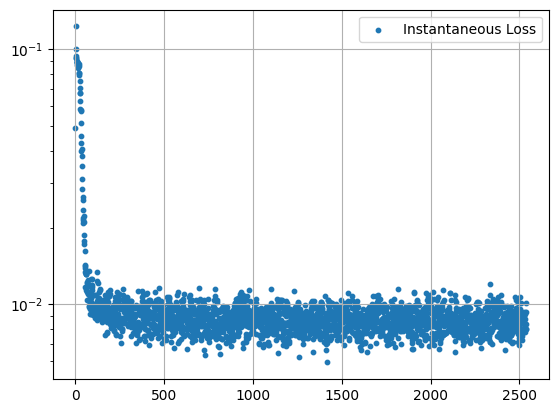

2539

In [91]:
with open((config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/")+ "_loss"), 'rb') as f:
        losses = (np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])
plt.scatter(Nepochs_losses,  losses, s=10, label="Instantaneous Loss")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()
plt.close()
Nepochs_losses[-1]

0.007856346920772911 0.008113292644645265
0.008642973524833734


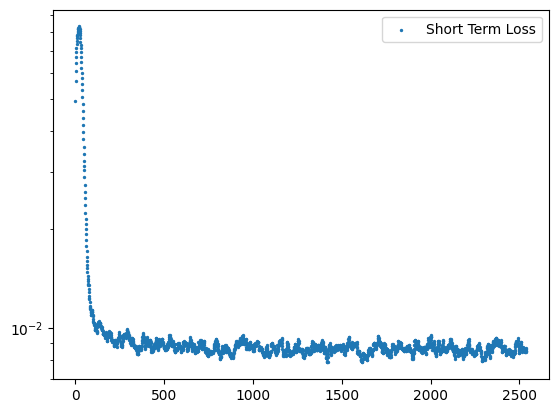

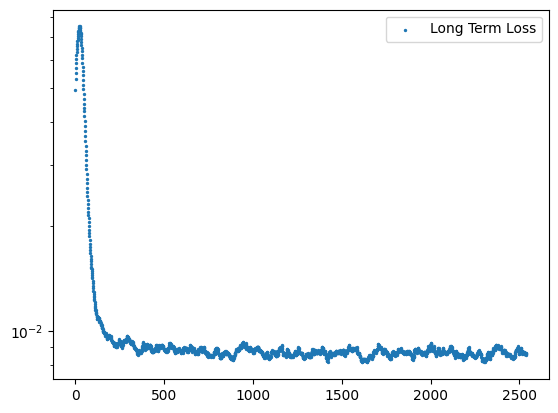

In [92]:
plot_ewma_losses(epochs=Nepochs_losses, losses=losses)

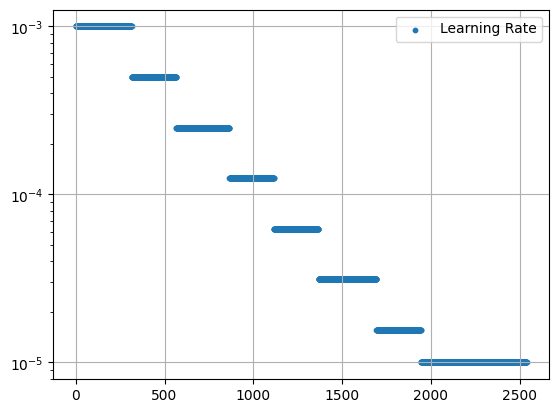

In [93]:
with open((config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/")+ "_loss_LR"), 'rb') as f:
        LRs = (np.array(pickle.load(f)).astype(float))
start = 0
end = -1
plt.scatter(np.arange(LRs.shape[0]),  LRs, s=10, label="Learning Rate")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()
plt.close()

In [94]:
if "fQuadSin" in config.data_path:
    minx = -1.5
    assert config.sin_space_scale == 25.
    ts_type = "fQuadSin2"
    include = (f"{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c").replace(
        ".", "")
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/QuadSinHF2/"
elif "fBiPot" in config.data_path:
    minx = -1.5
    ts_type = "fBiPot"
    include = (f"{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c").replace(
        ".", "")
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/BiPot/"
elif "fSinLog" in config.data_path:
    minx = -1.5
    ts_type = "fSinLog"
    include = (f"{config.deltaT:.3e}dT_{config.log_space_scale}b_{config.sin_space_scale}c").replace(
        ".", "")
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/SinLog/"
maxx = -minx

In [95]:
def get_drift_files(config, include, ts_type_str, root_score_dir):
    ts_type = f"{ts_type_str}"
    driftevalexp_files = []
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_score_dir):
        if "MLP" in file and ts_type in file and include in file:
            if (("ST" in ts_type_str and "_ST_" in file) or (("ST" not in ts_type_str and "_ST_" not in file))):
                if "muhats" in file and "DriftEvalExp" in file:
                    driftevalexp_files.append(root_score_dir+file)
                elif "OOSDriftTrack" in file and "true" in file:
                    driftoostrack_true_files.append(root_score_dir+file)
                elif "OOSDriftTrack" in file and "global" in file:
                    driftoostrack_local_files.append(root_score_dir+file)
    def extract_bw_drift_eval_exp_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftevalexp_files = sorted(driftevalexp_files, key=extract_bw_drift_eval_exp_number)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    Nepochs_drifteval = [extract_bw_drift_eval_exp_number(f) for f in driftevalexp_files]
    return driftevalexp_files, driftoostrack_true_files, driftoostrack_local_files, Nepochs_track, Nepochs_drifteval

In [96]:
if "BiPot" in config.data_path:
    ts_type_str = f"ST_{config.feat_thresh:.3f}FTh_fBiPot".replace(".", "")
    dirname = "BiPot"
    label = "$\mu_{3}$"
elif "QuadSinHF" in config.data_path:
    ts_type_str = f"ST_{config.feat_thresh:.3f}FTh_fQuadSinHF".replace(".","")
    dirname = "QuadSinHF2"
    label = "$\mu_{2}$"
elif "SinLog" in config.data_path:
    ts_type_str = f"ST_{config.feat_thresh:.3f}FTh_fSinLog".replace(".","")
    dirname = "SinLog"
    label = "$\mu_{1}$"
driftevalexp_files, driftoostrack_true_files, driftoostrack_local_files, Nepochs_track, Nepochs_drifteval = get_drift_files(config=config, include=include, ts_type_str=ts_type_str, root_score_dir=root_score_dir)

In [97]:
eval_exp_rmses = {}
for f in zip(*[Nepochs_drifteval, driftevalexp_files]):
    Nepoch = f[0]
    file = f[1]
    try:
        muhats = torch.Tensor(np.load(file, allow_pickle=True))
        Xshape = muhats.shape[0]
        Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))
        if "BiPot" in config.data_path:
            true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).numpy()
        elif "QuadSin" in config.data_path:
            true_drifts = (-2. * config.quad_coeff * Xs + config.sin_coeff * config.sin_space_scale * np.sin(
        config.sin_space_scale * Xs)).numpy()
        elif "SinLog" in config.data_path:
            true_drifts = (-np.sin(config.sin_space_scale*Xs)*np.log(1+config.log_space_scale*np.abs(Xs))/config.sin_space_scale).numpy()
        mu_hats = muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[2]*1).mean(dim=-1).numpy()
        rmse = rmse_ignore_nans(true_drifts, mu_hats).astype(np.float64)
        eval_exp_rmses.update({Nepoch: round(rmse, 6)})
    except [FileNotFoundError, pickle.UnpicklingError] as e:
        continue
Nepochs_drifteval = np.array(list(eval_exp_rmses.keys())).flatten()
eval_exp_rmses

{1: 3.784025,
 2: 0.438806,
 4: 0.387083,
 6: 0.377152,
 8: 0.404234,
 10: 0.342933,
 12: 0.333154,
 14: 0.320791,
 16: 0.335773,
 18: 0.316712,
 20: 0.288091,
 22: 0.228332,
 24: 0.1232,
 26: 0.09704,
 28: 0.086804,
 30: 0.076666,
 32: 0.06331,
 34: 0.041374,
 36: 0.03653,
 38: 0.11493,
 40: 0.084644,
 42: 0.069019,
 44: 0.030257,
 46: 0.032869,
 48: 0.053323,
 50: 0.115403,
 52: 0.019659,
 54: 0.070828,
 56: 0.030914,
 58: 0.011865,
 60: 0.012048,
 62: 0.055581,
 64: 0.223224,
 66: 0.15893,
 68: 0.115593,
 70: 0.04056,
 72: 0.020736,
 74: 0.012854,
 76: 0.061022,
 78: 0.055577,
 80: 0.023767,
 82: 0.030199,
 84: 0.159123,
 86: 0.040723,
 88: 0.026126,
 90: 0.016744,
 92: 0.008538,
 94: 0.183016,
 96: 0.175159,
 98: 0.038673,
 100: 0.013195,
 102: 0.020358,
 104: 0.052837,
 106: 0.020022,
 108: 0.018006,
 110: 0.020992,
 112: 0.020319,
 114: 0.007981,
 116: 0.015885,
 118: 0.019234,
 120: 0.032333,
 122: 0.030644,
 124: 0.056208,
 126: 0.028281,
 128: 0.024883,
 130: 0.010664,
 132: 0

In [98]:
drift_track_rmses = {}
for f in zip(*[Nepochs_track, driftoostrack_true_files, driftoostrack_local_files]):
    Nepoch = f[0]
    true = f[1]
    local = f[2]
    try:
        all_true_states = np.load(true, allow_pickle=True)
        all_local_states= np.load(local,allow_pickle=True)
        global_error = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        total_local_errors = np.sqrt(np.mean(global_error.reshape(-1, global_error.shape[-1]), axis=0))
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
    except pickle.UnpicklingError as e:
        print(e)
        continue
    except (FileNotFoundError, ValueError) as e:
        print(e)
        continue
Nepochs_track= np.array(list(drift_track_rmses.keys())).flatten()

In [99]:
common_epochs = np.intersect1d(np.intersect1d(np.intersect1d(Nepochs_losses, Nepochs_drifteval), Nepochs_track), np.arange(50, 3500))
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = [np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs]
evalexp_idx = [np.argwhere(c == Nepochs_drifteval)[0,0] for c in common_epochs]
red_losses = losses[losses_idx]
eval_rmses = np.array(list(eval_exp_rmses.values()))[evalexp_idx]
track_idx = [np.argwhere(c == Nepochs_track)[0,0] for c in common_epochs]
track_rmses = np.array(list(drift_track_rmses.values()))[track_idx]

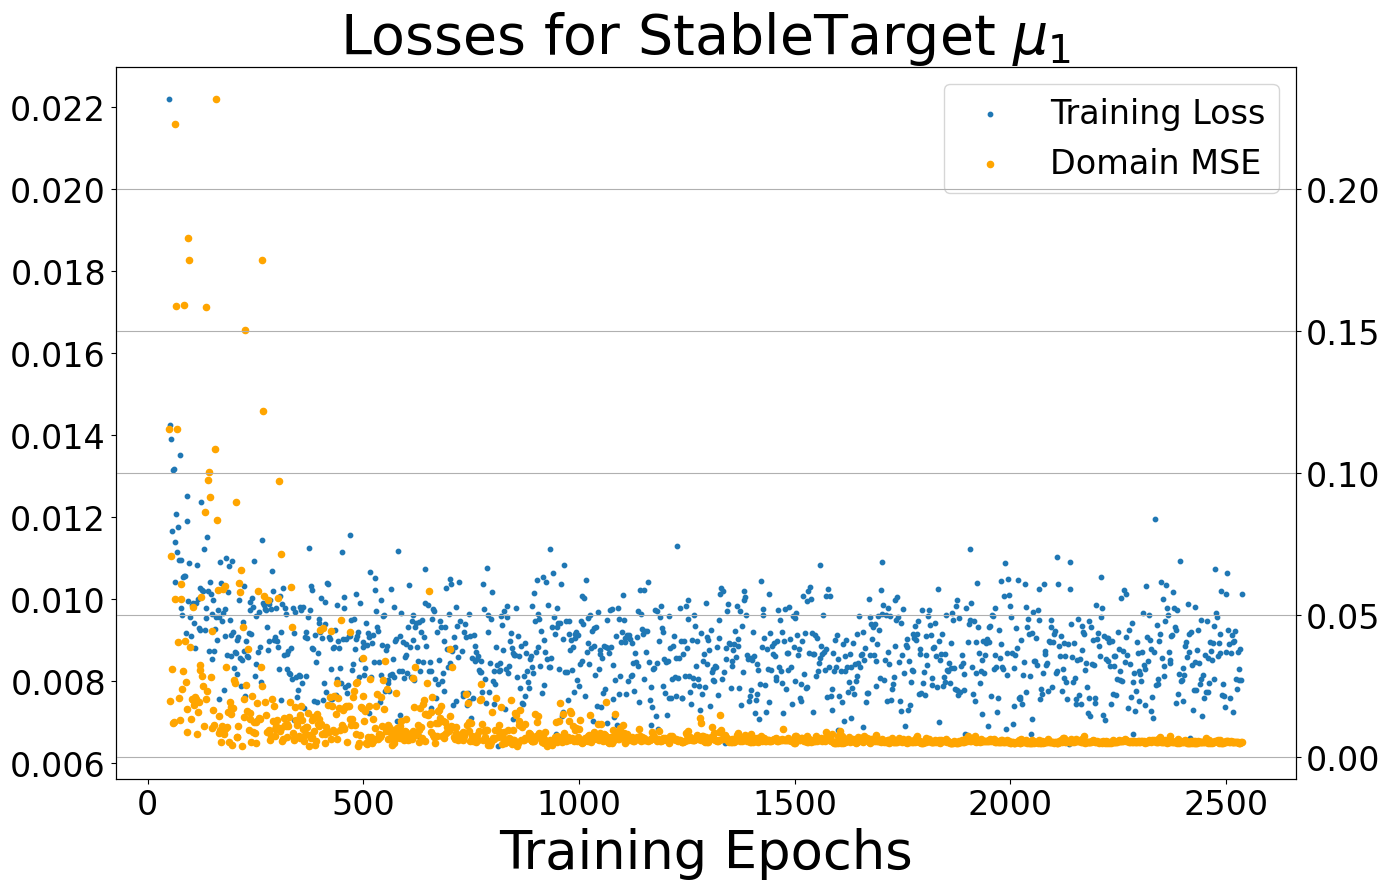

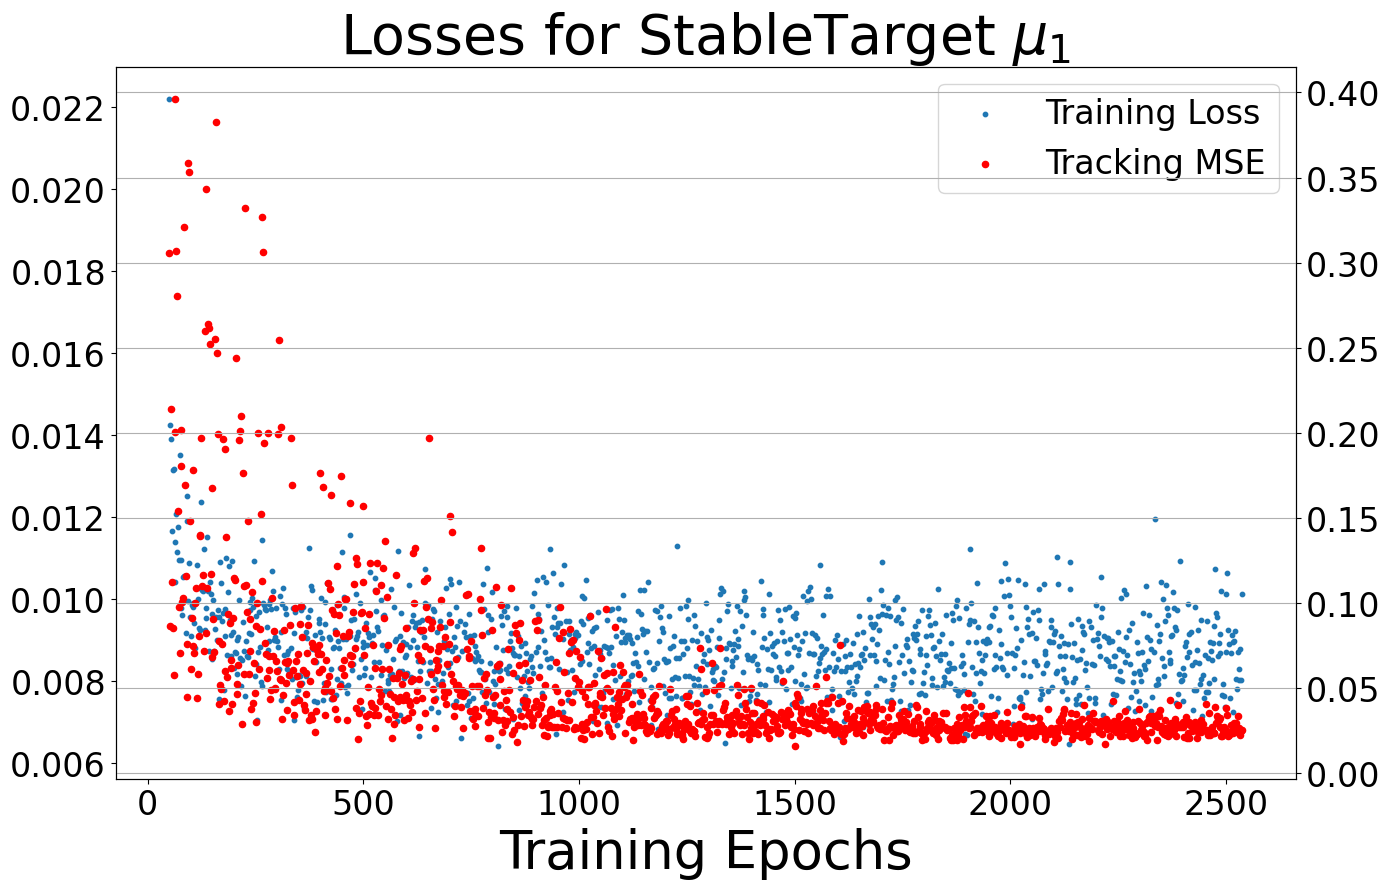

In [100]:
toSave = True
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax.tick_params(axis="both",labelsize=24)
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, eval_rmses, s=20, color="orange",label="Domain MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(rf"Losses for StableTarget {label}", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
ax.legend(handles, labels, fontsize=24)
if toSave:
    plt.savefig((root_dir +f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{ts_type}_LossesEvalExp_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.grid(True)
plt.show()
plt.close()
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, track_rmses, s=20, color="red",label="Tracking MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(rf"Losses for StableTarget {label}", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    plt.savefig((root_dir + f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{ts_type}_LossesTrack_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.grid(True)
plt.show()
plt.close()

0.008102507584778538 0.008272506201192126
0.008669028305019746


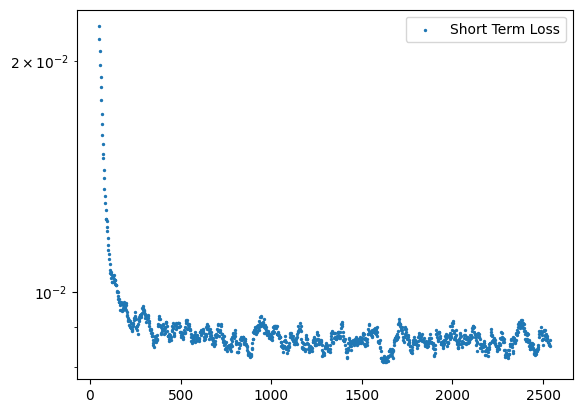

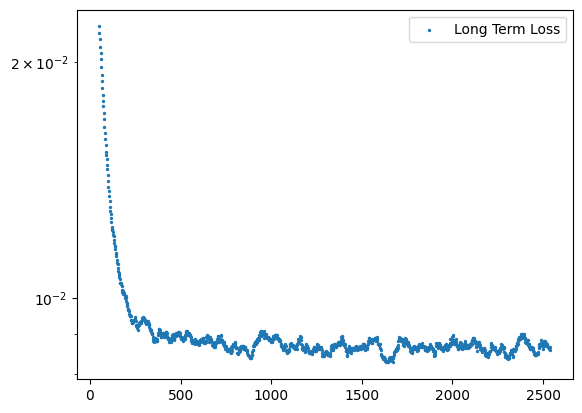

In [101]:
plot_ewma_losses(epochs=common_epochs, losses=red_losses)

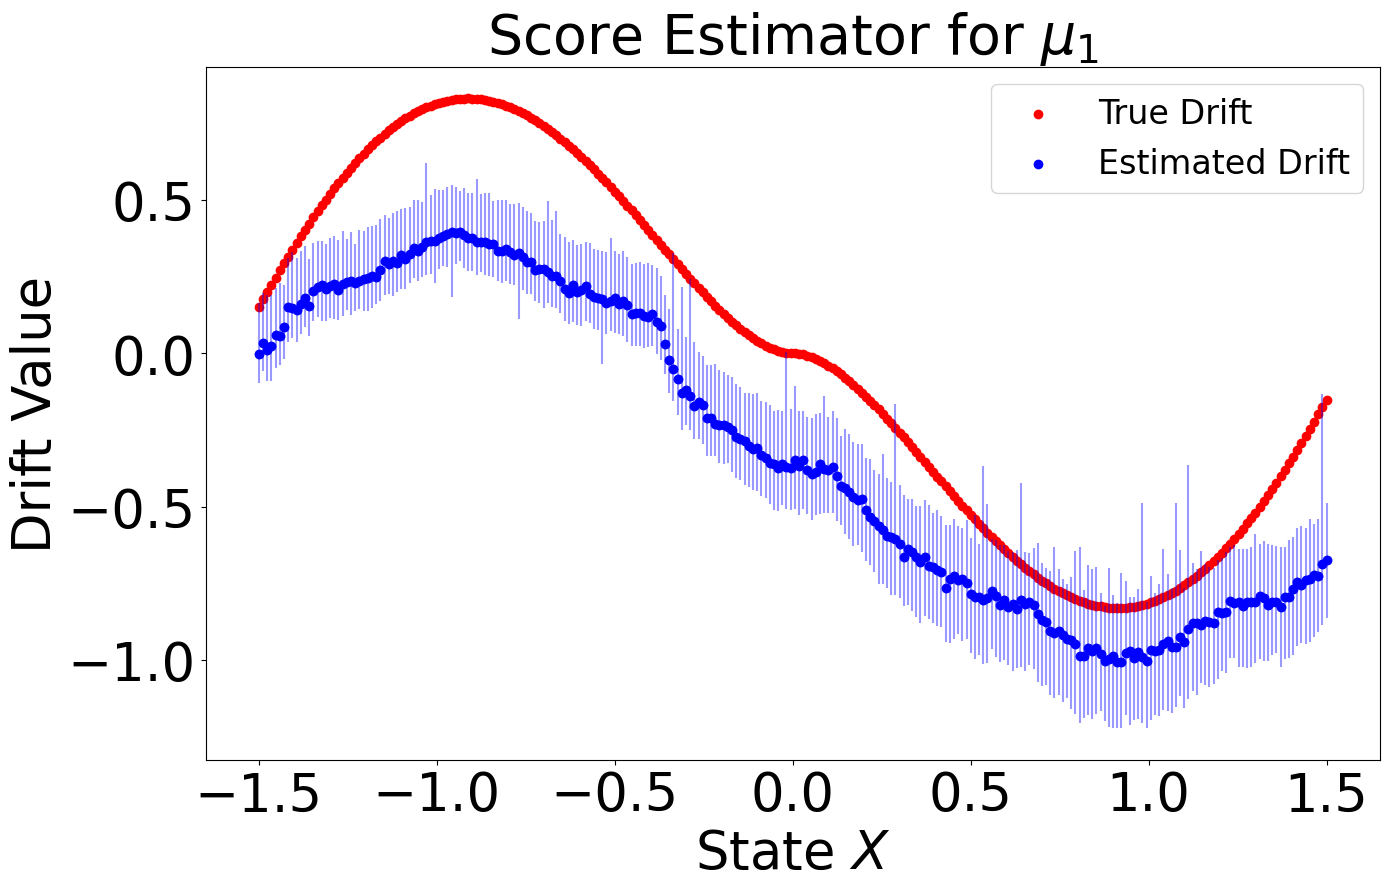

MSE 0.11540298163890839 at Nepoch 50



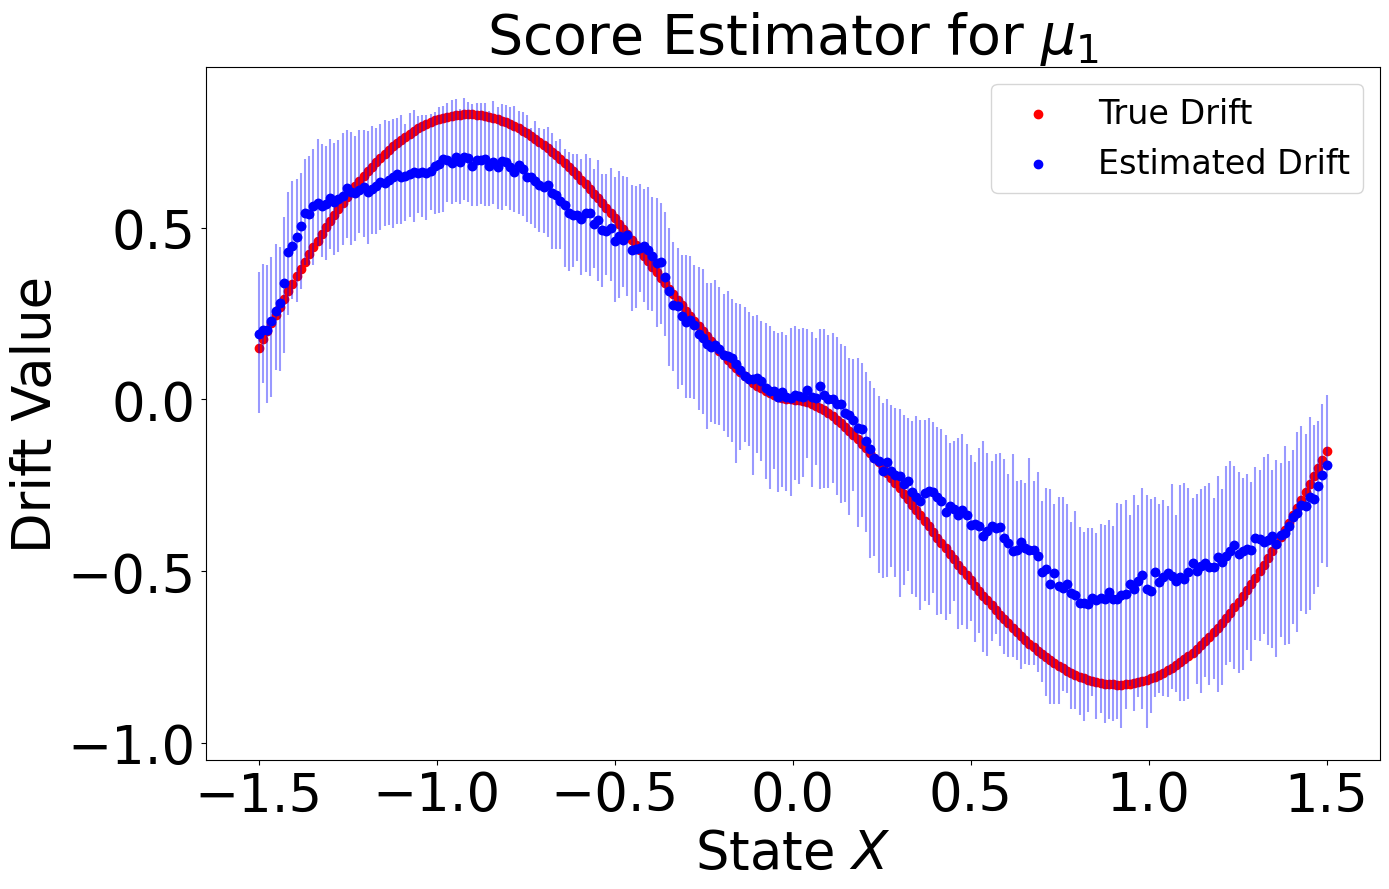

MSE 0.0196585264056921 at Nepoch 52



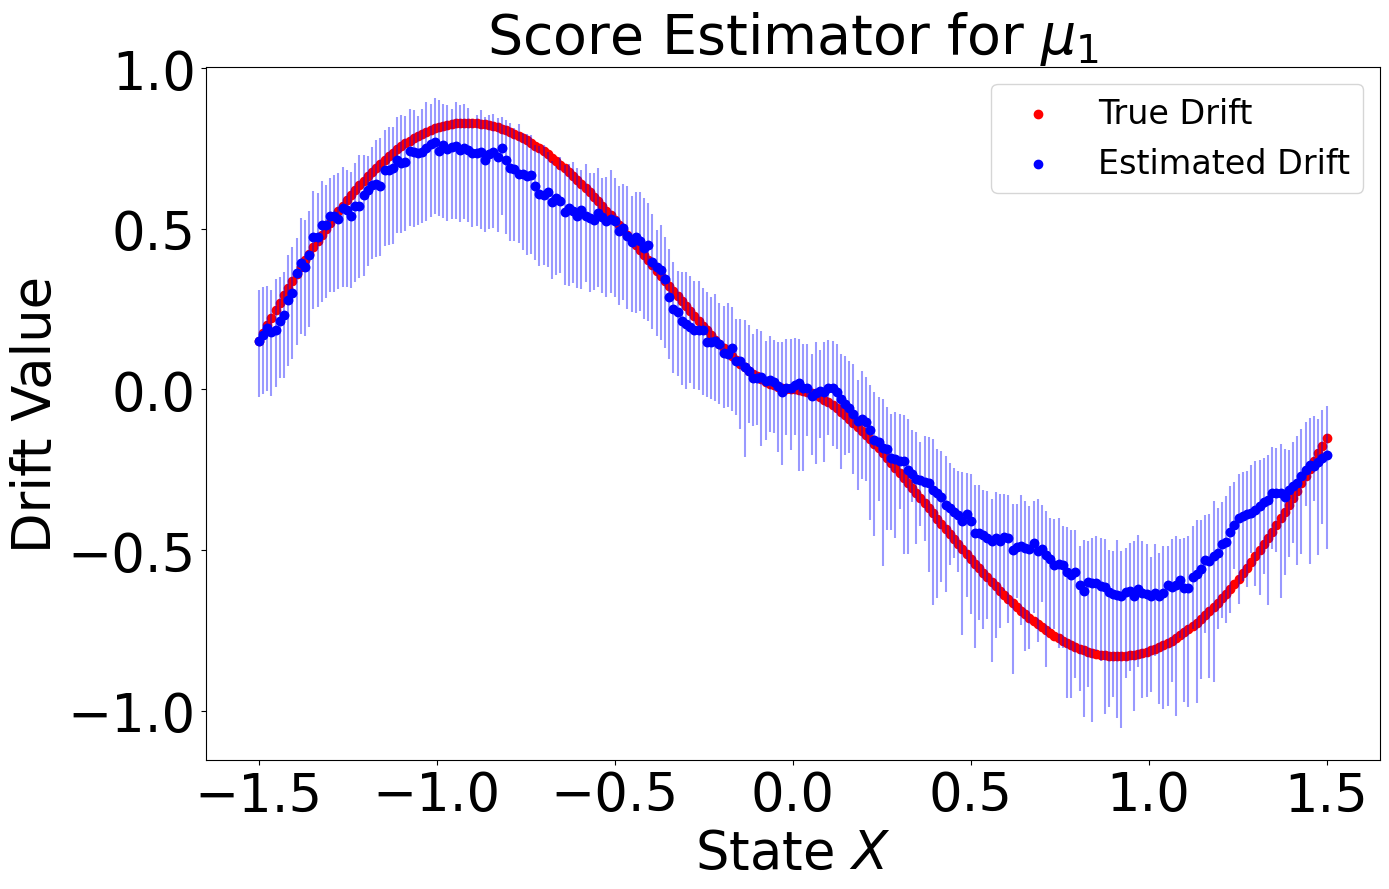

MSE 0.011865059845149517 at Nepoch 58



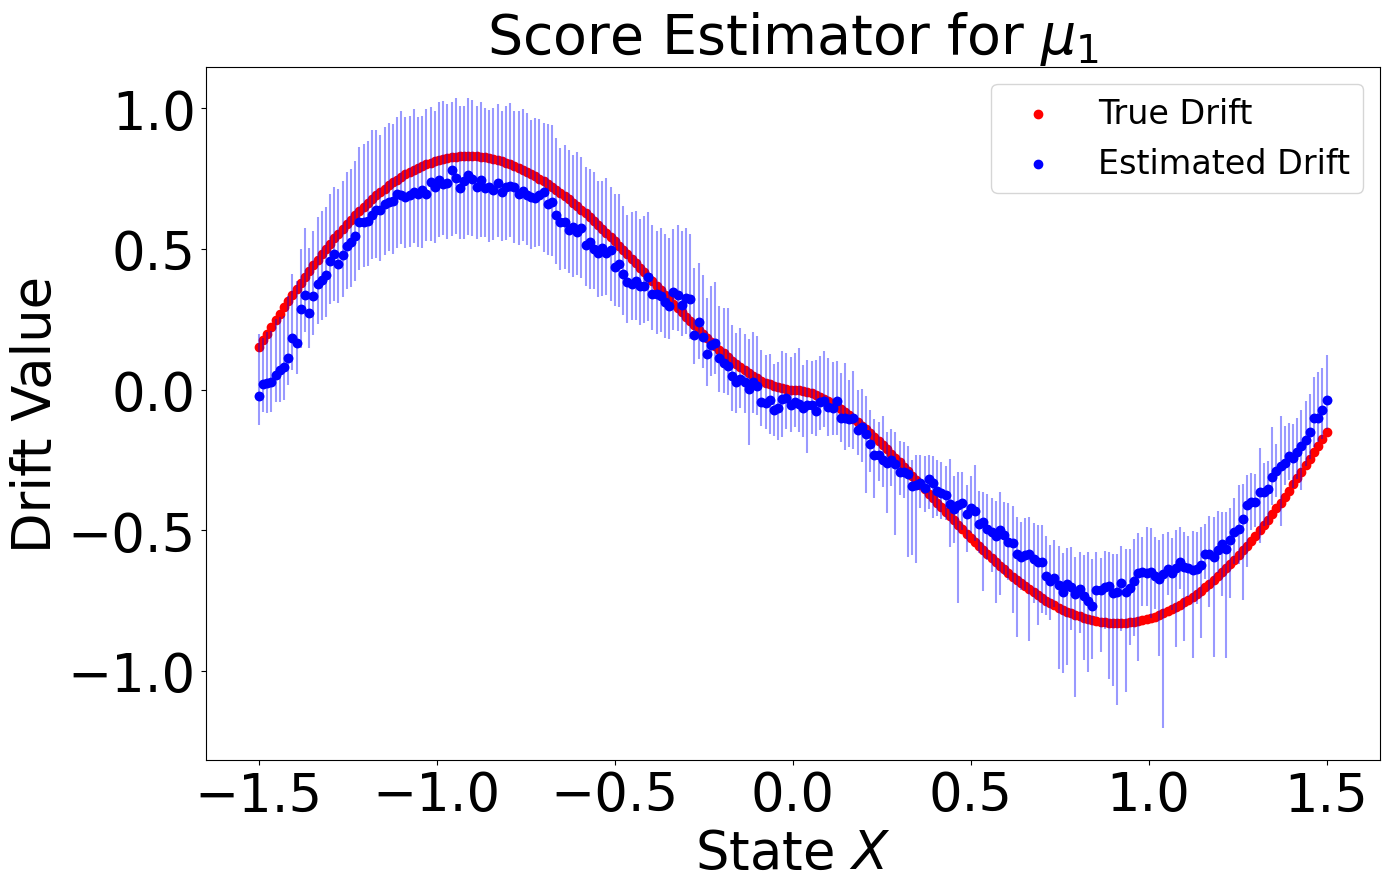

MSE 0.008538393303751945 at Nepoch 92



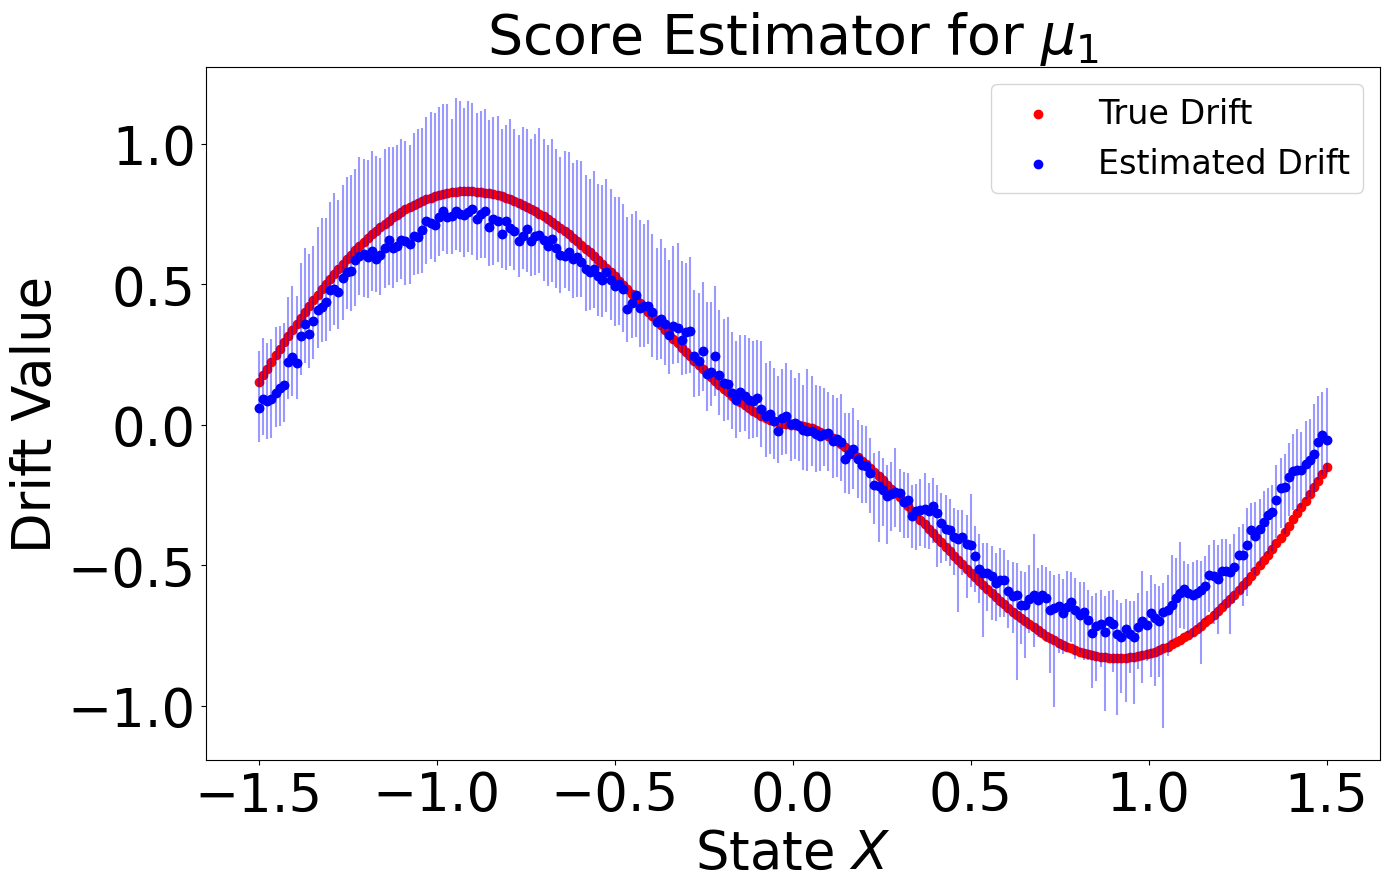

MSE 0.007981454022228718 at Nepoch 114



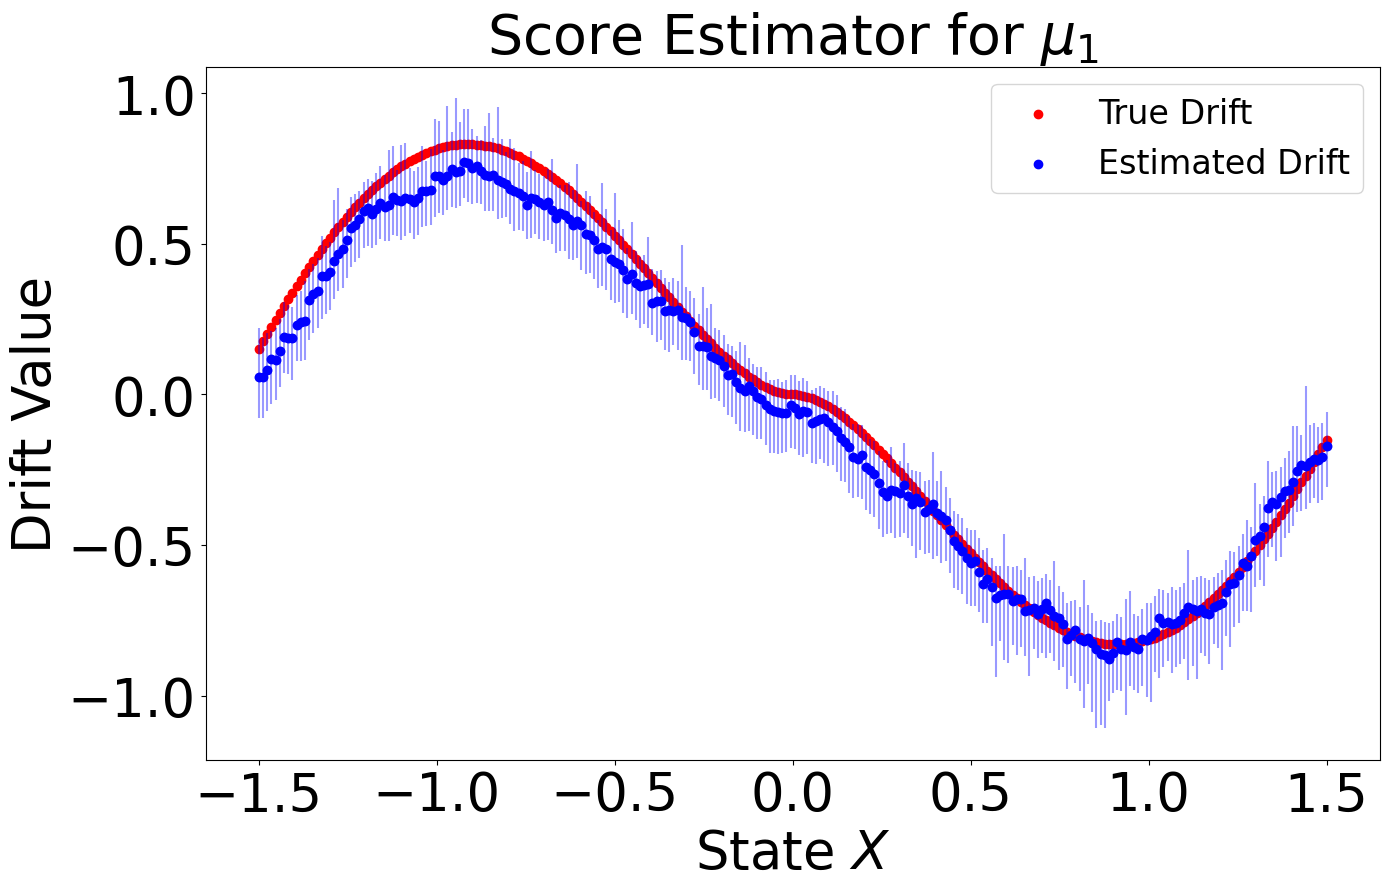

MSE 0.005148604512214661 at Nepoch 170



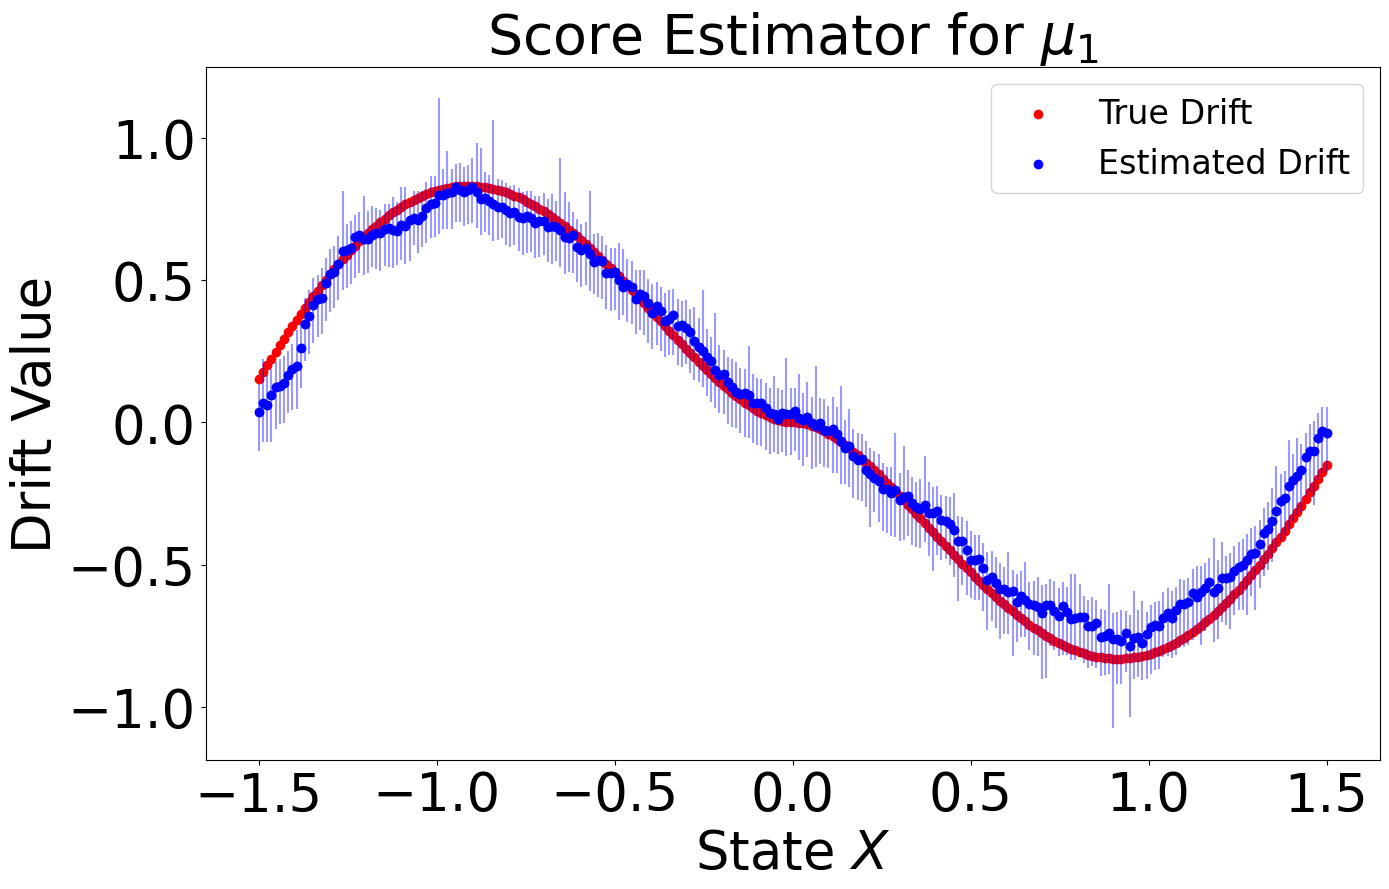

MSE 0.004986550193279982 at Nepoch 188



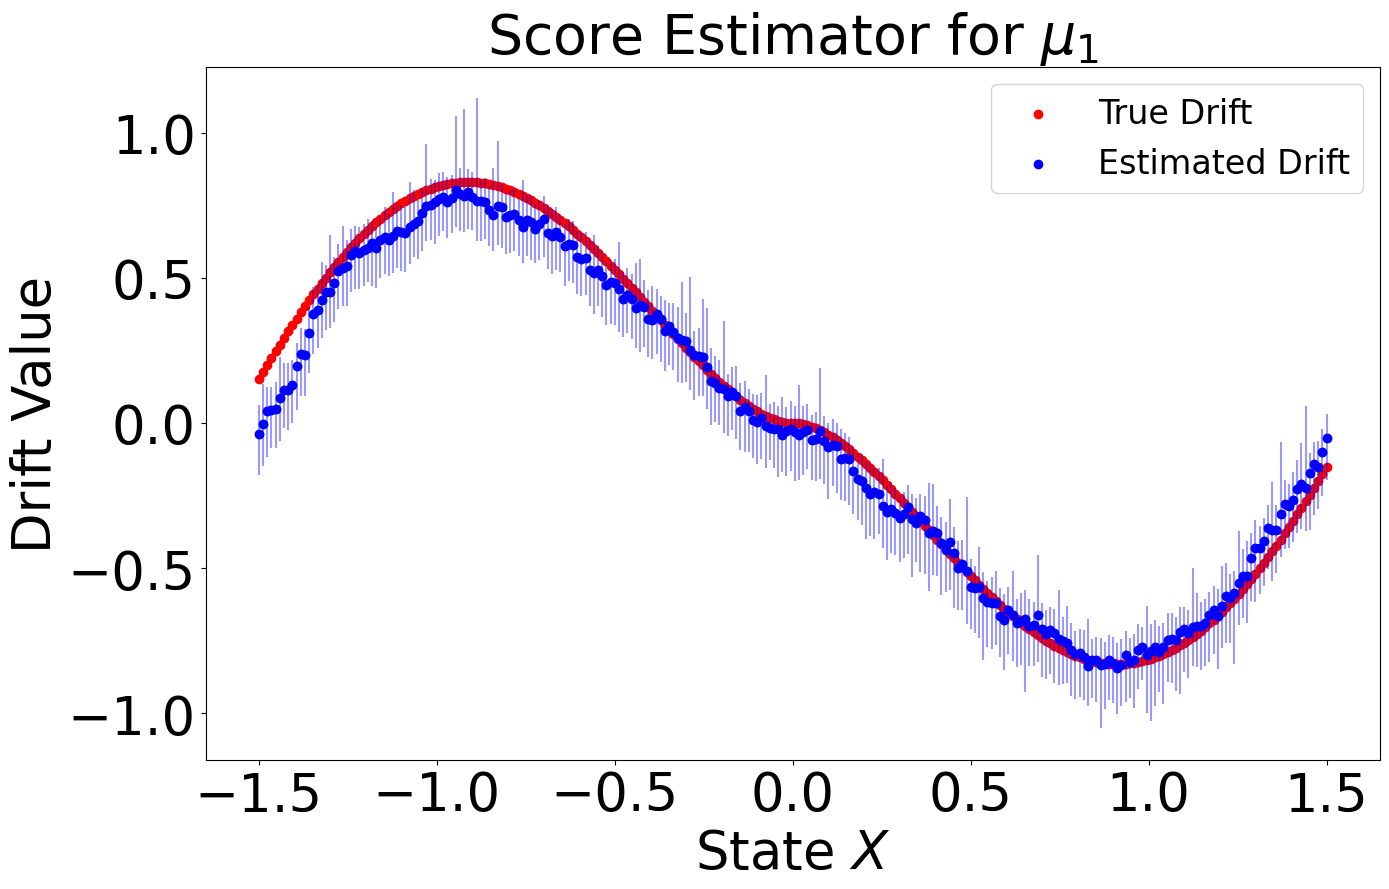

MSE 0.0041251350194215775 at Nepoch 196



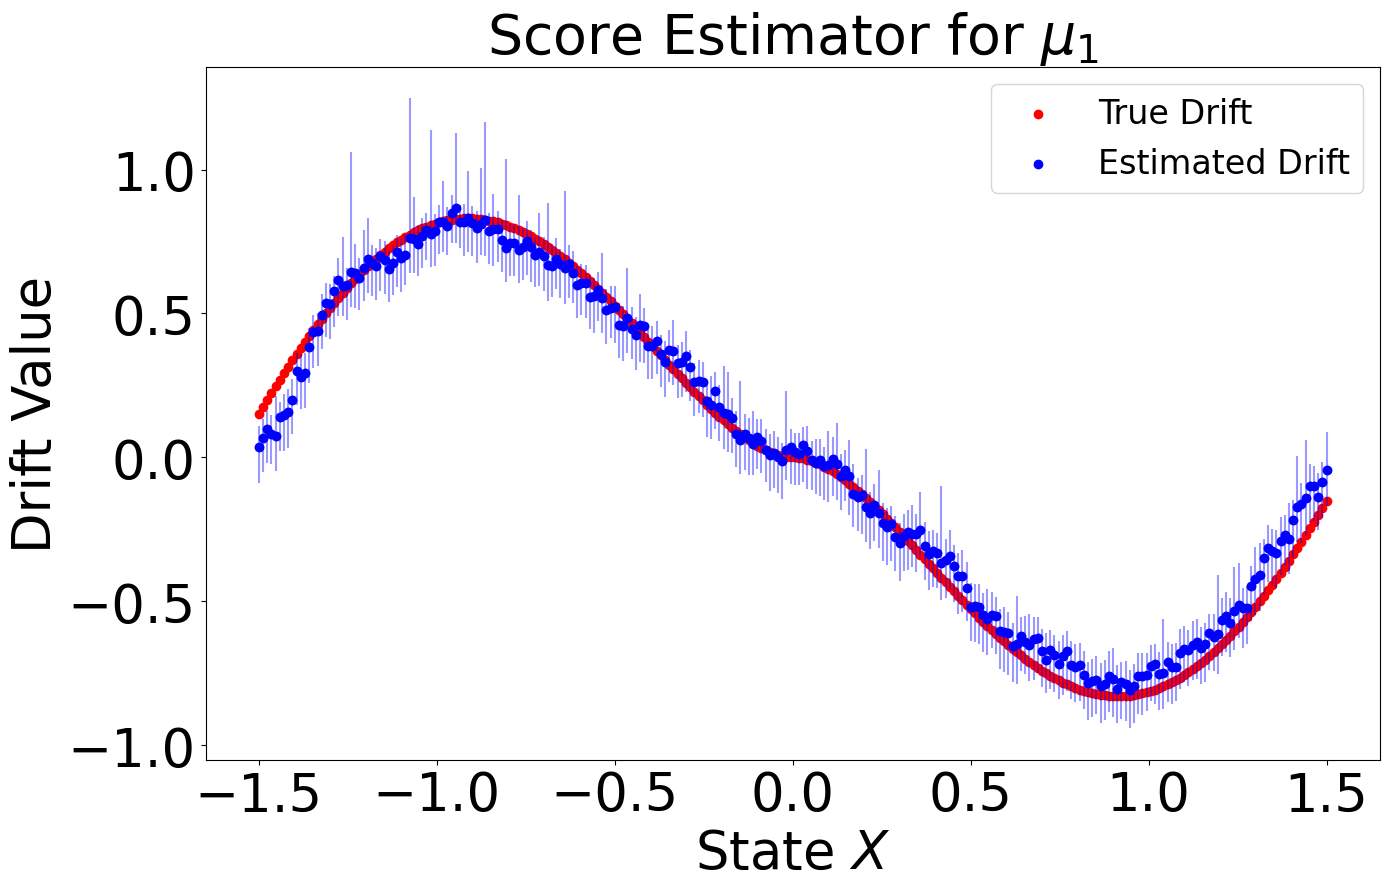

MSE 0.0036689089611172676 at Nepoch 218



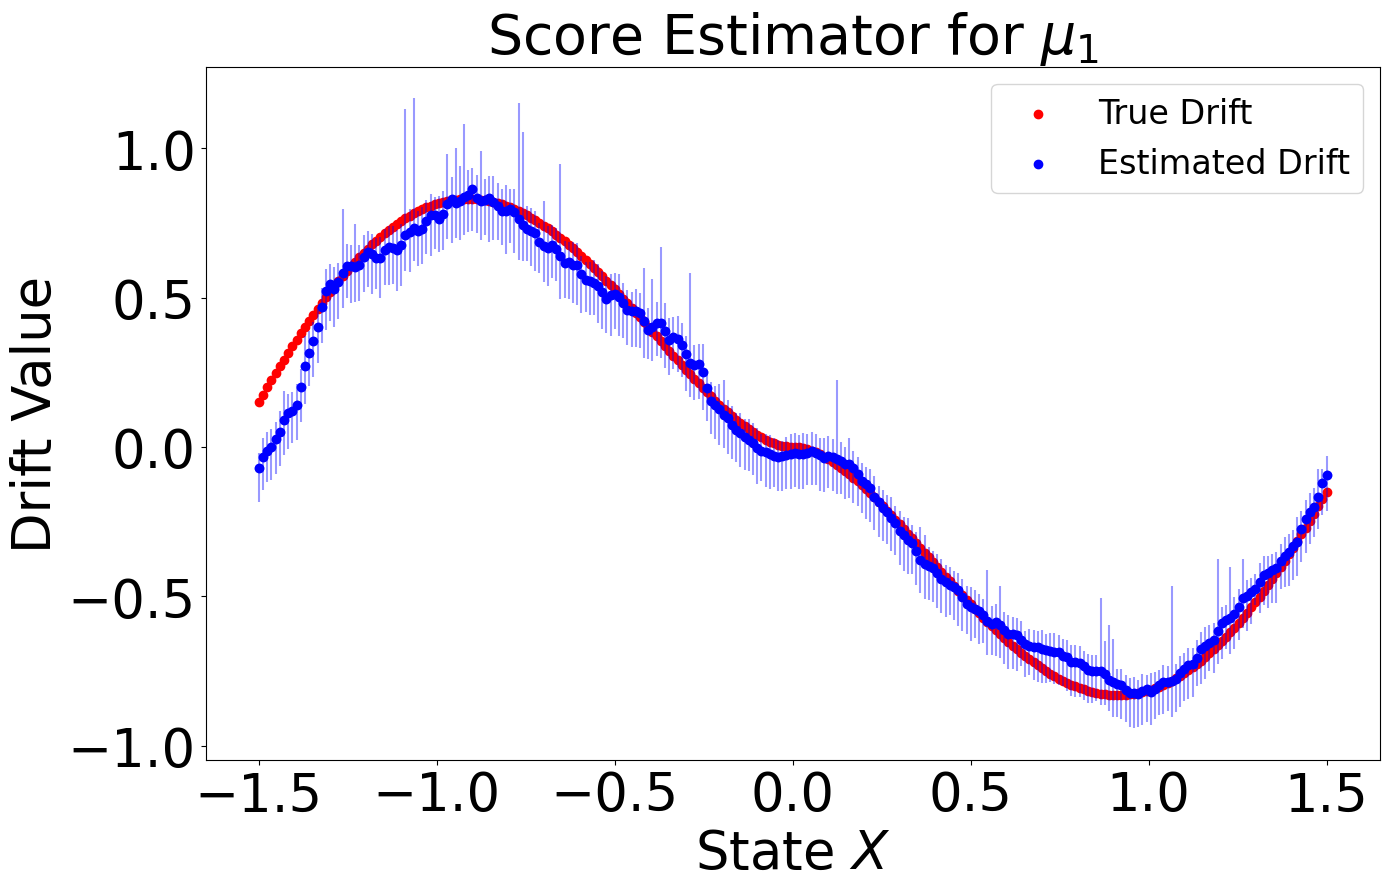

MSE 0.0035881241783499718 at Nepoch 488



In [105]:
best_rmse = np.inf
toSave = True
for f in zip(*[Nepochs_drifteval, driftevalexp_files]):
    Nepoch = f[0]
    file = f[1]
    if Nepoch not in common_epochs: continue
    try:
        muhats = torch.Tensor(np.load(file, allow_pickle=True))
        Xshape = muhats.shape[0]
        Xs = torch.linspace(-1.5, 1.5, steps=Xshape)
        if "fQuadSin" in config.data_path:
            true_drifts = -2.*config.quad_coeff * Xs.unsqueeze(-1) + config.sin_coeff * config.sin_space_scale*np.sin(config.sin_space_scale*Xs).unsqueeze(-1)
        elif "BiPot" in config.data_path:
            true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).unsqueeze(-1)
        elif "SinLog" in config.data_path:
            true_drifts =  -np.sin(config.sin_space_scale*Xs)*np.log(1+config.log_space_scale*np.abs(Xs))/config.sin_space_scale
        true_drifts = true_drifts.numpy().flatten()
        muhats =  muhats[:, -1, :, 0].reshape(muhats.shape[0], muhats.shape[2]*1)
        mu_hats = muhats.mean(dim=-1).numpy() # Pointwise drift estimate
        mu_hats_minq = muhats.quantile(dim=-1, q=0.005).numpy() # Lower bound
        mu_hats_maxq = muhats.quantile(dim=-1, q=0.995).numpy() # Upper bound
        stds = muhats.std(dim=-1).numpy()
        rmse = rmse_ignore_nans(true_drifts, mu_hats).astype(np.float64)
        if rmse < best_rmse:
            best_rmse = rmse
            plot_drift_estimator(mean=mu_hats, mean_min=mu_hats_minq, mean_max=mu_hats_maxq, dirname=dirname, numpy_Xs=Xs.numpy(),  toSave=toSave, true_drift=true_drifts, Nepoch=Nepoch, label=label)
            print(f"MSE {rmse} at Nepoch {Nepoch}\n")
        del muhats, mu_hats, stds, true_drifts
    except FileNotFoundError as e:
        print(f"{e}, Hi")


/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_23765/4191449353.py:12: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean((all_local_errors), axis=0))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_23765/4191449353.py:13: RuntimeWarning: invalid value encountered in divide
  all_errs = np.sqrt(all_local_errors)/np.sqrt(time_steps)


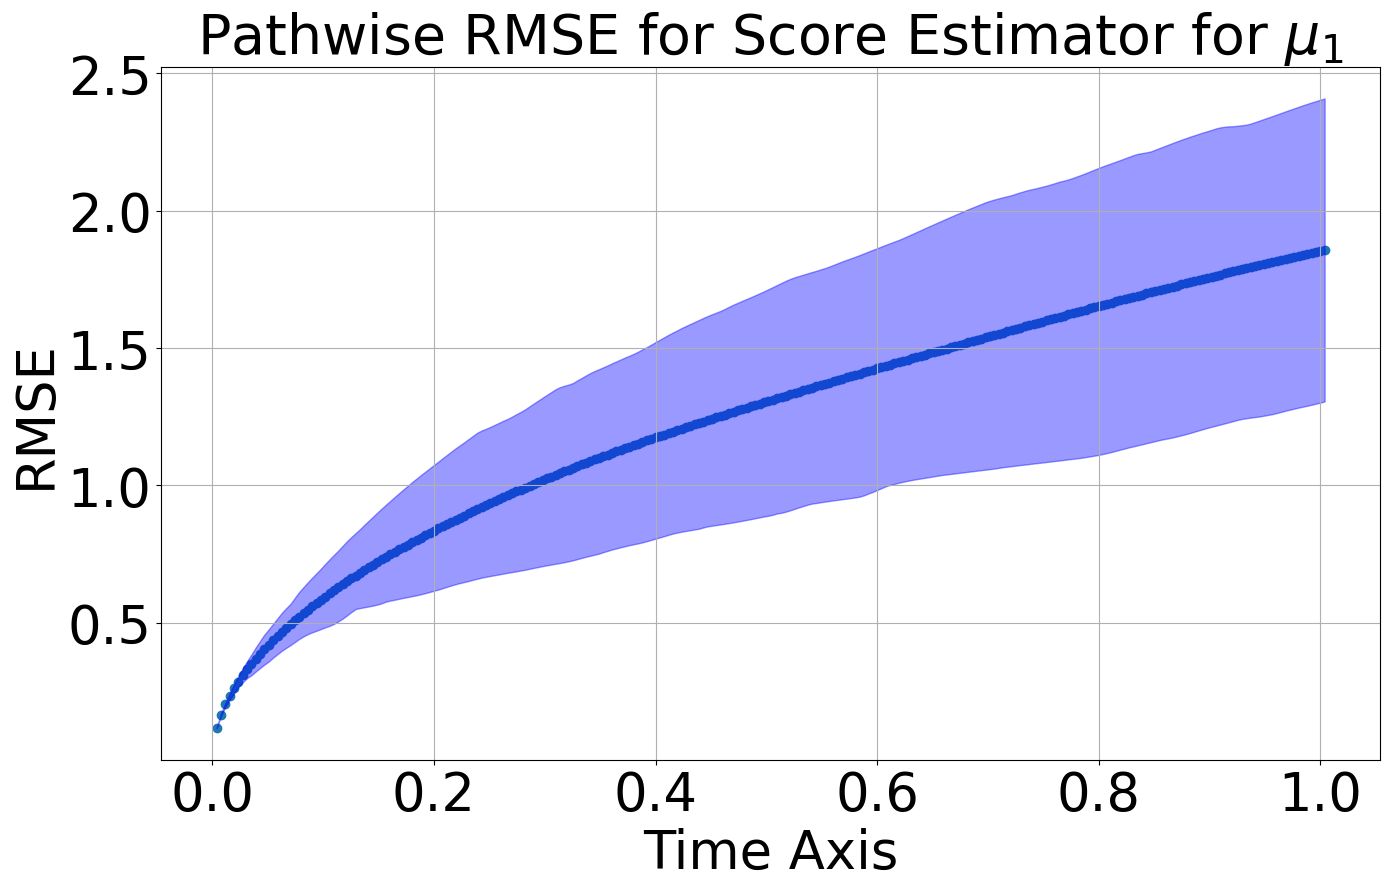

Final time cumulative MSE local-time error 1.8585793075083306 with IQR ((1.3052491146309881, 2.408755846350522))at Nepoch 50



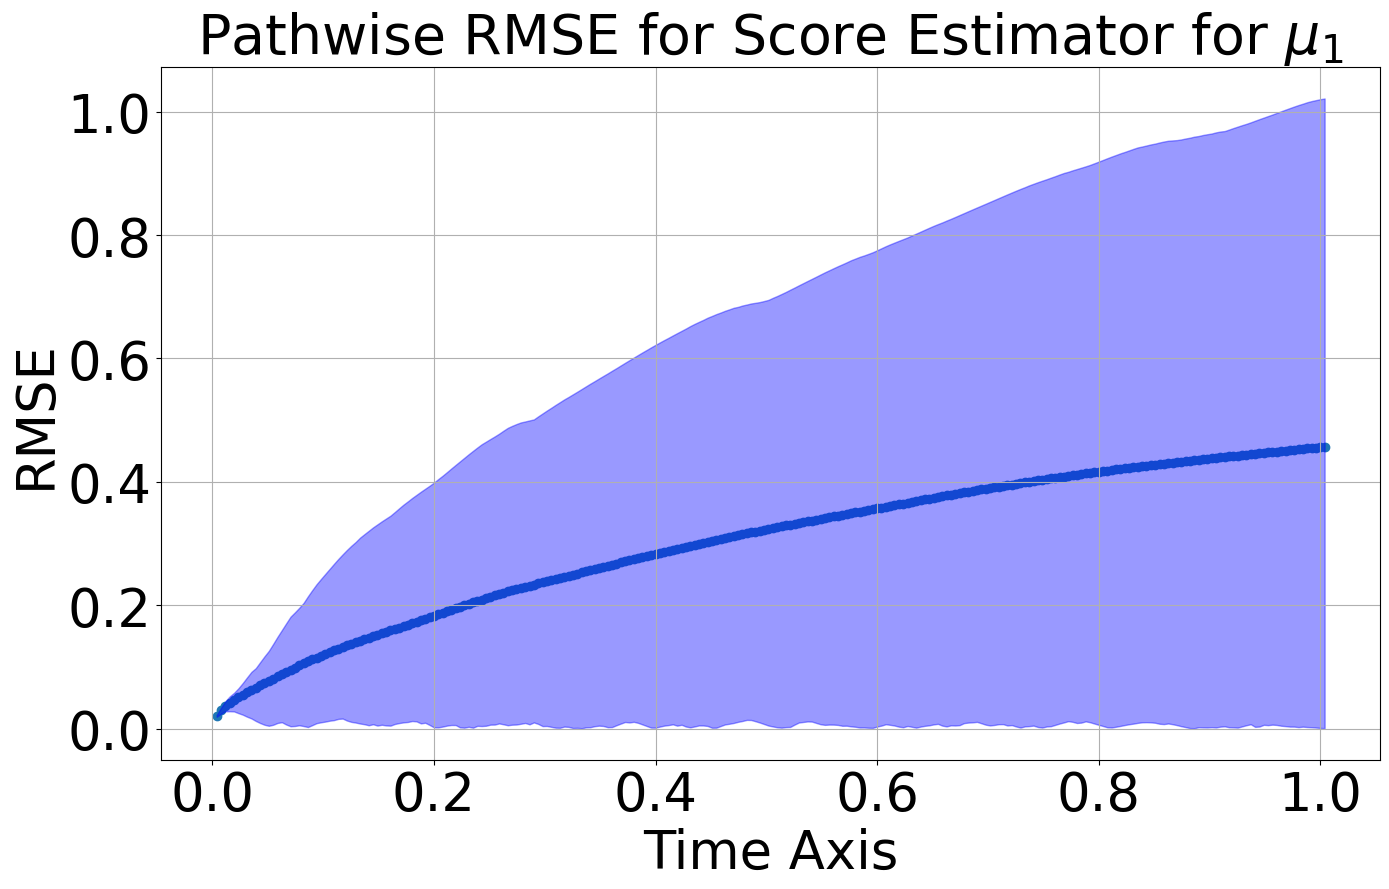

Final time cumulative MSE local-time error 0.45704374404189135 with IQR ((0.0006358790235656268, 1.021406426304158))at Nepoch 52



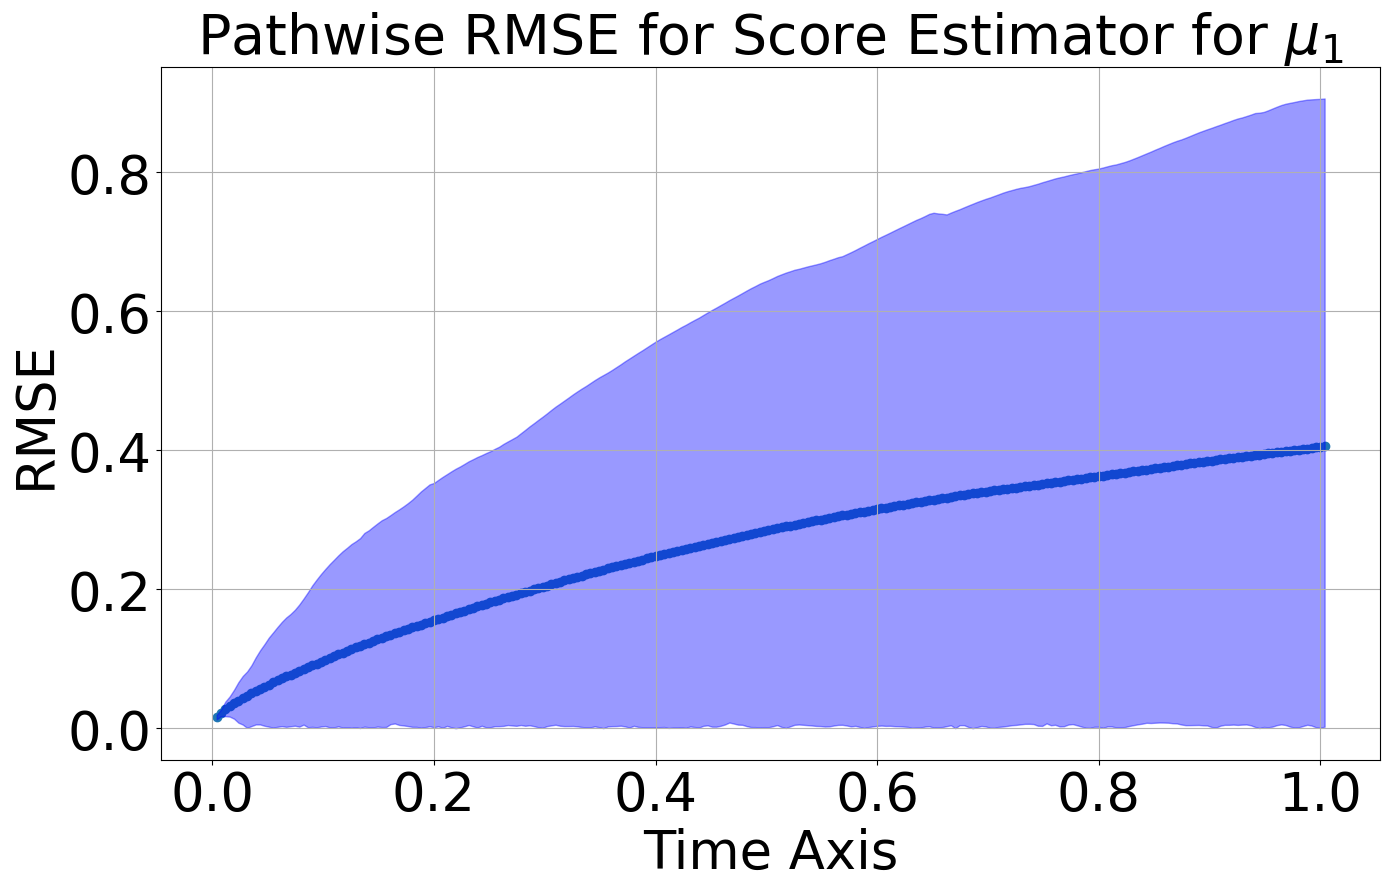

Final time cumulative MSE local-time error 0.40552205058814184 with IQR ((0.00237230411372931, 0.906141815803367))at Nepoch 54



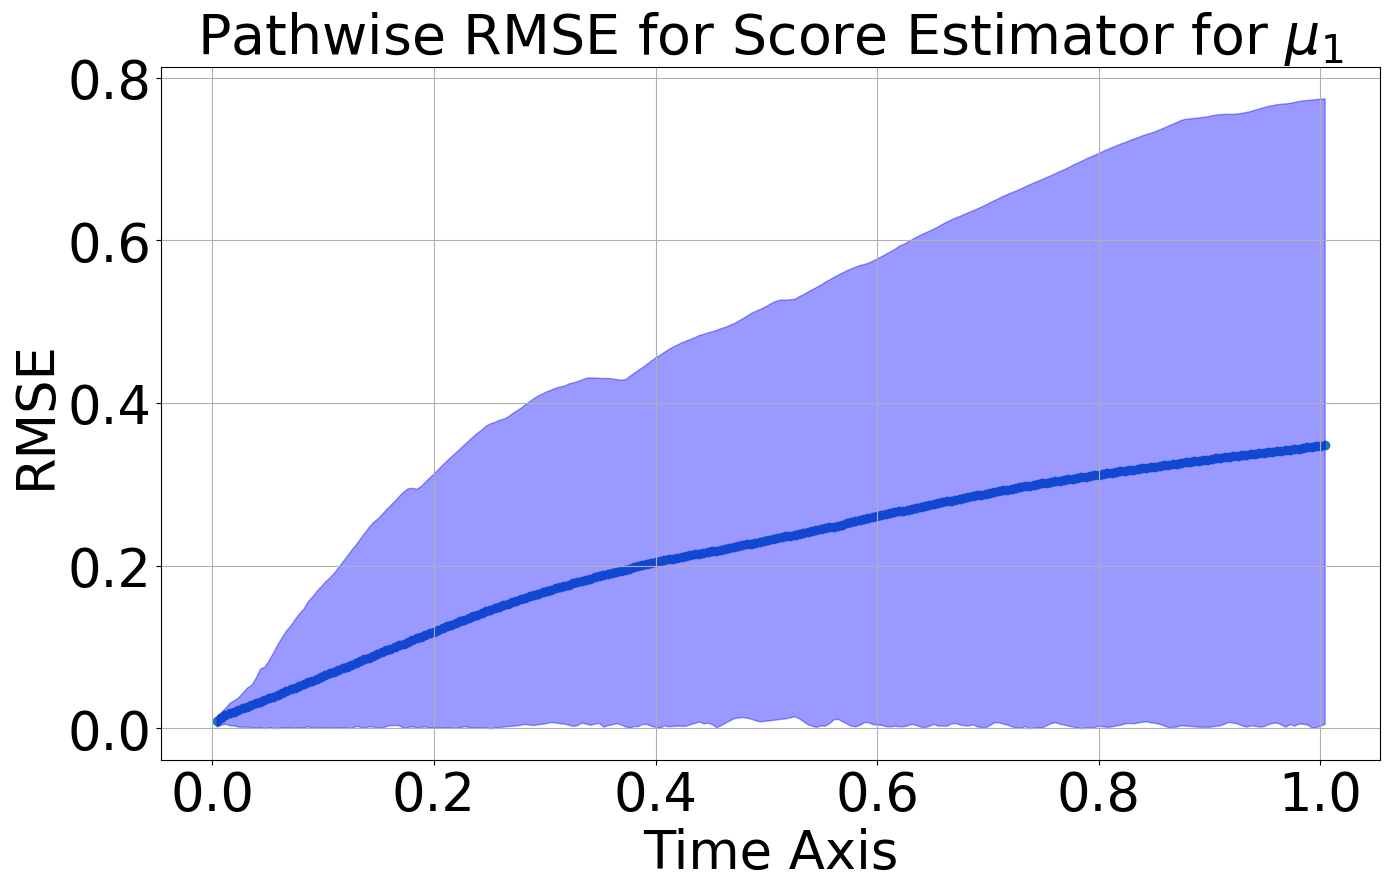

Final time cumulative MSE local-time error 0.34789636349082187 with IQR ((0.005568374259960215, 0.7743577408235056))at Nepoch 60



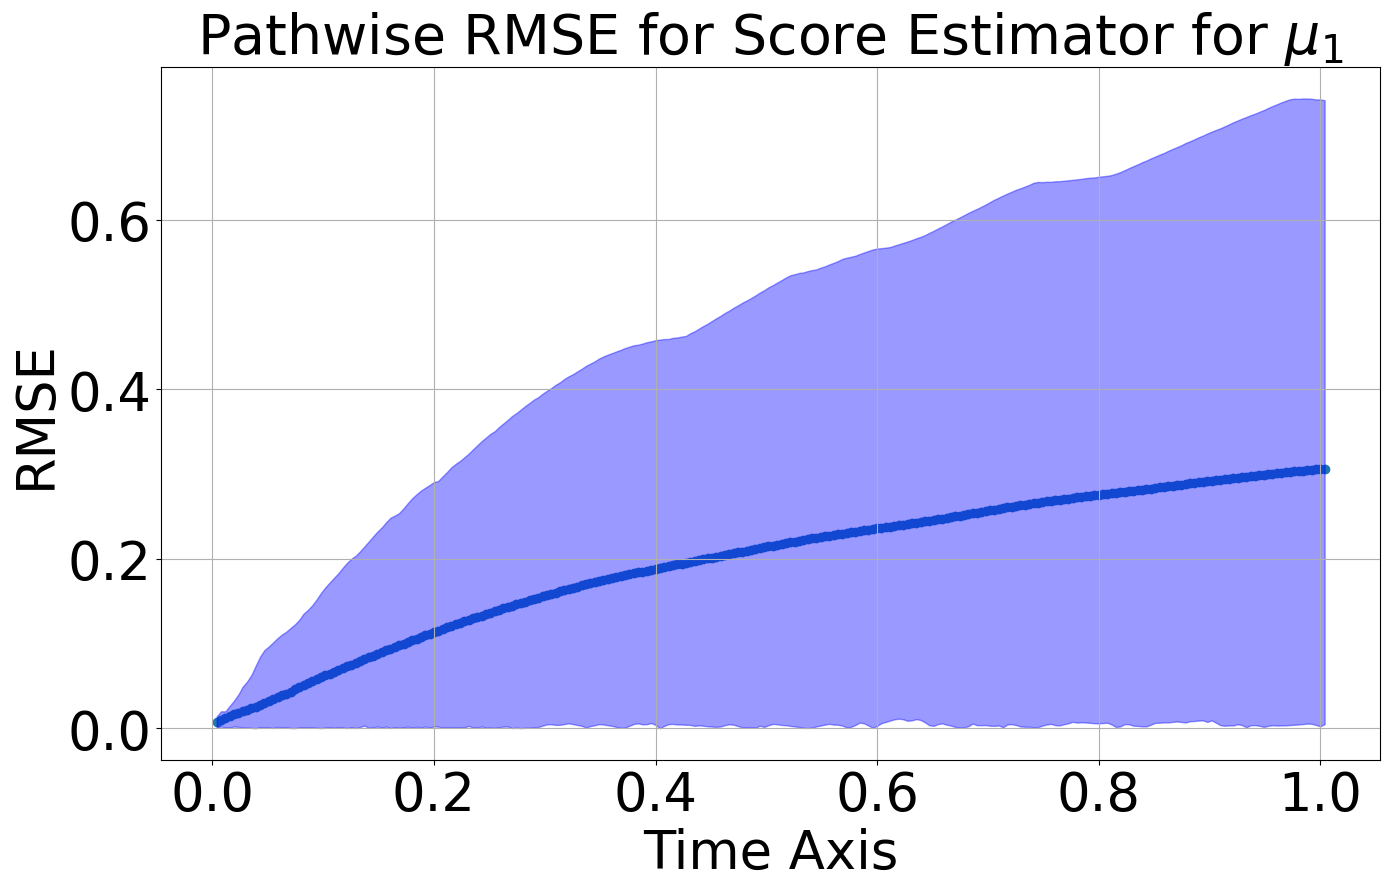

Final time cumulative MSE local-time error 0.30633692756269826 with IQR ((0.004836885045328159, 0.7412175884918615))at Nepoch 62



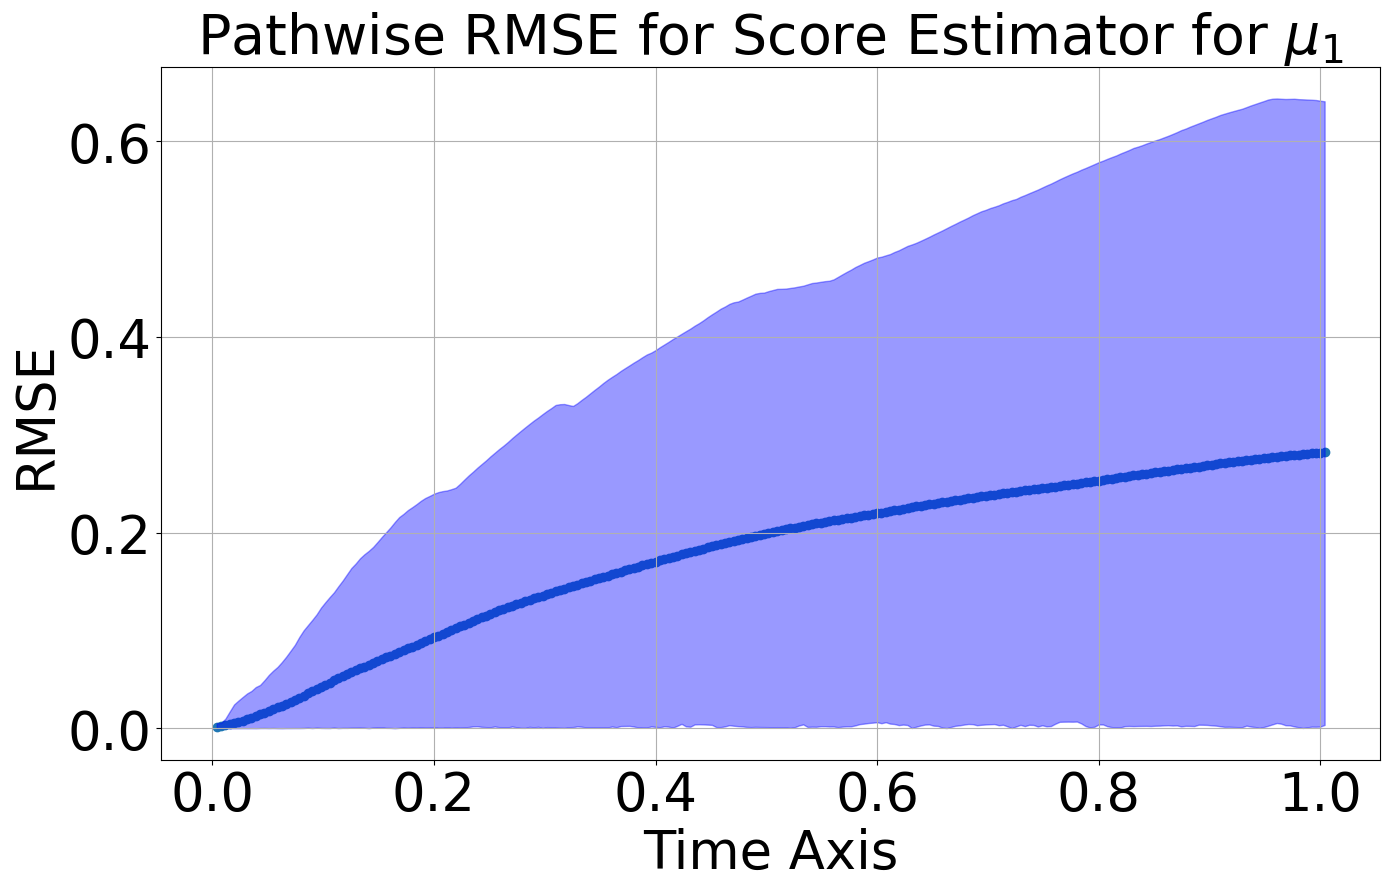

Final time cumulative MSE local-time error 0.2819989259621463 with IQR ((0.0033807451227673684, 0.6407586283002609))at Nepoch 70



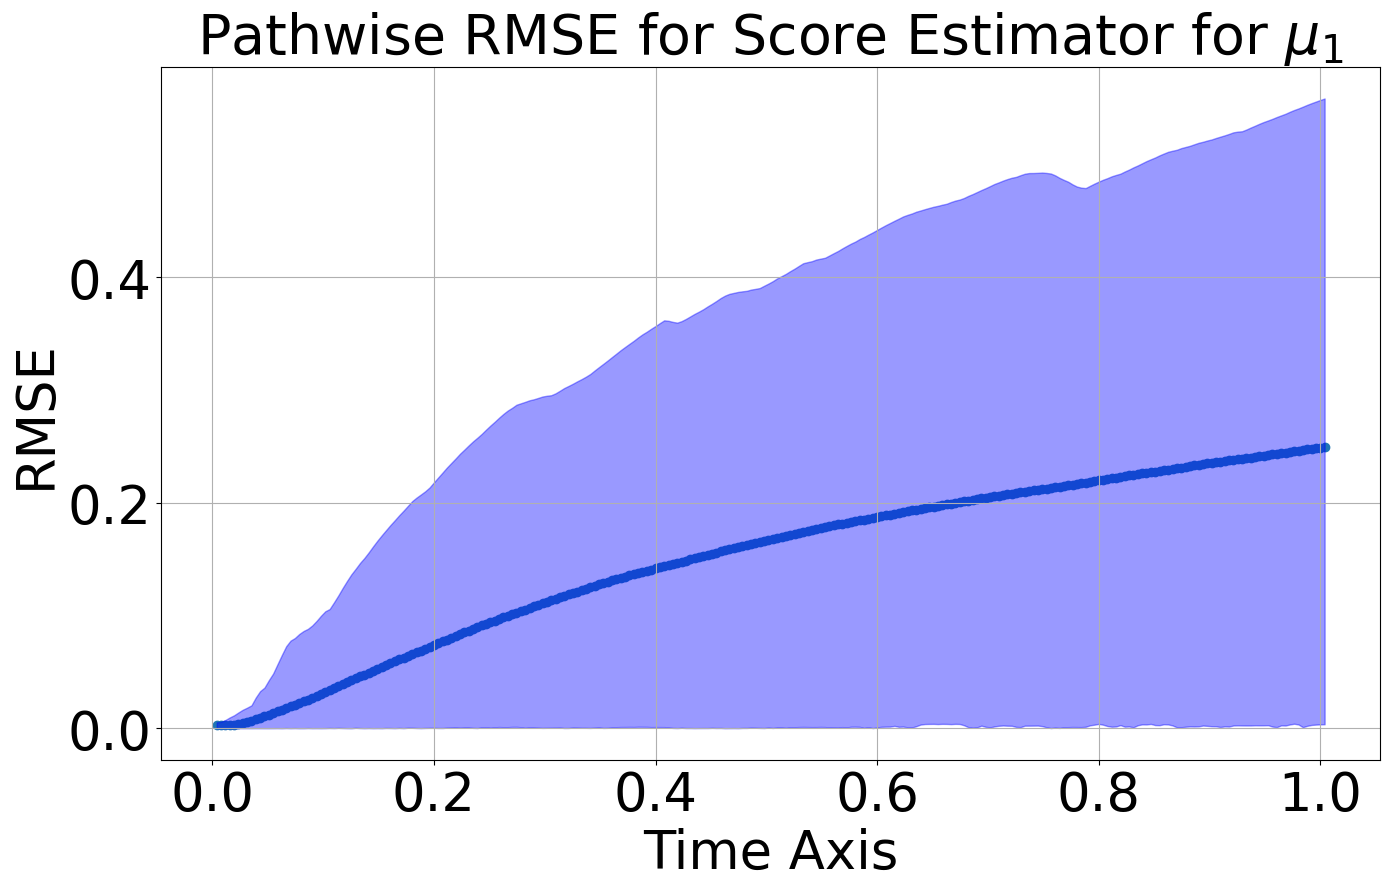

Final time cumulative MSE local-time error 0.24951158944077226 with IQR ((0.0035380456867582957, 0.5585389134890084))at Nepoch 72



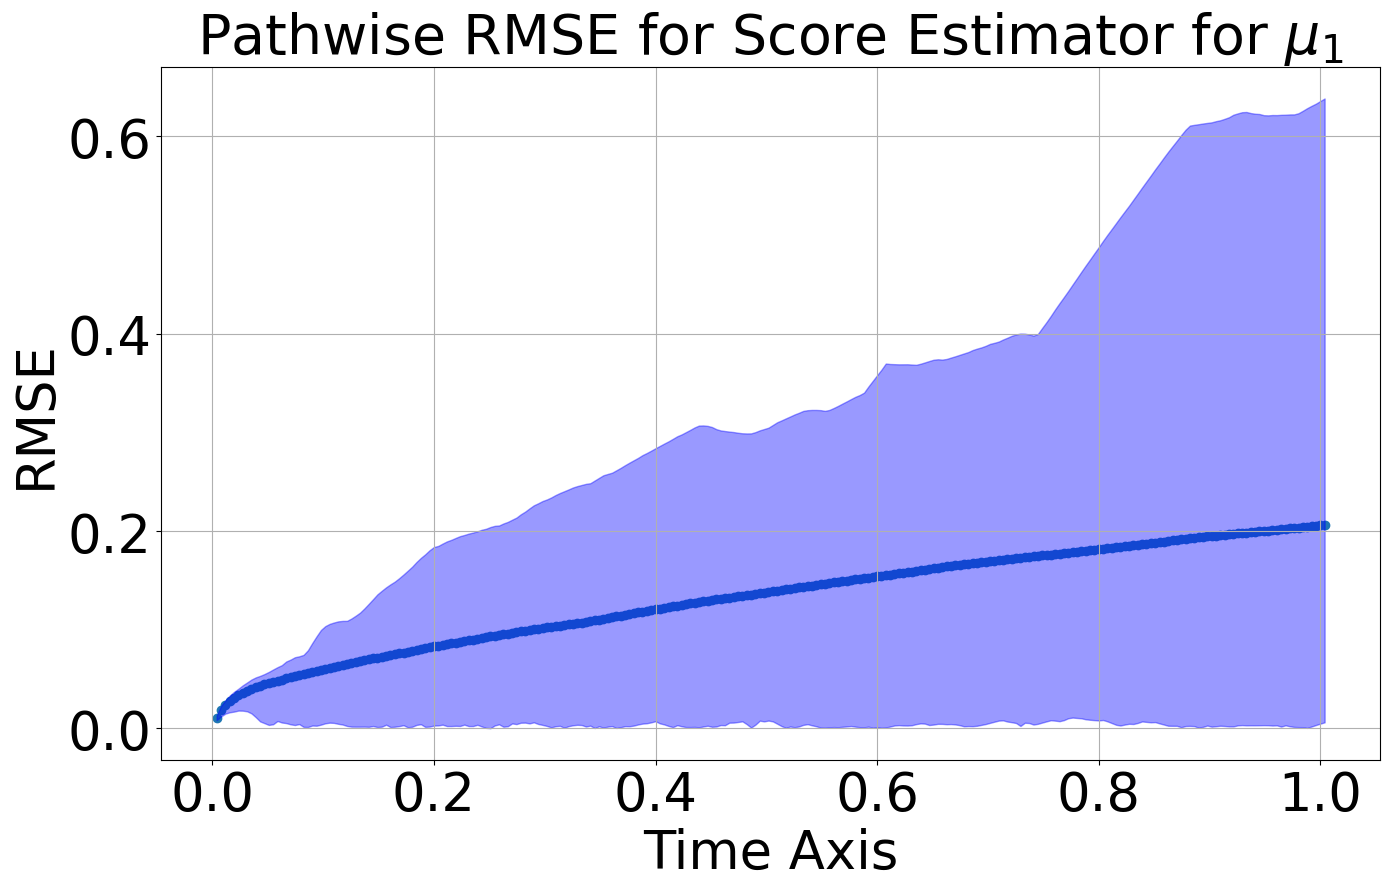

Final time cumulative MSE local-time error 0.20617554287415016 with IQR ((0.006094731730275753, 0.638465608664474))at Nepoch 74



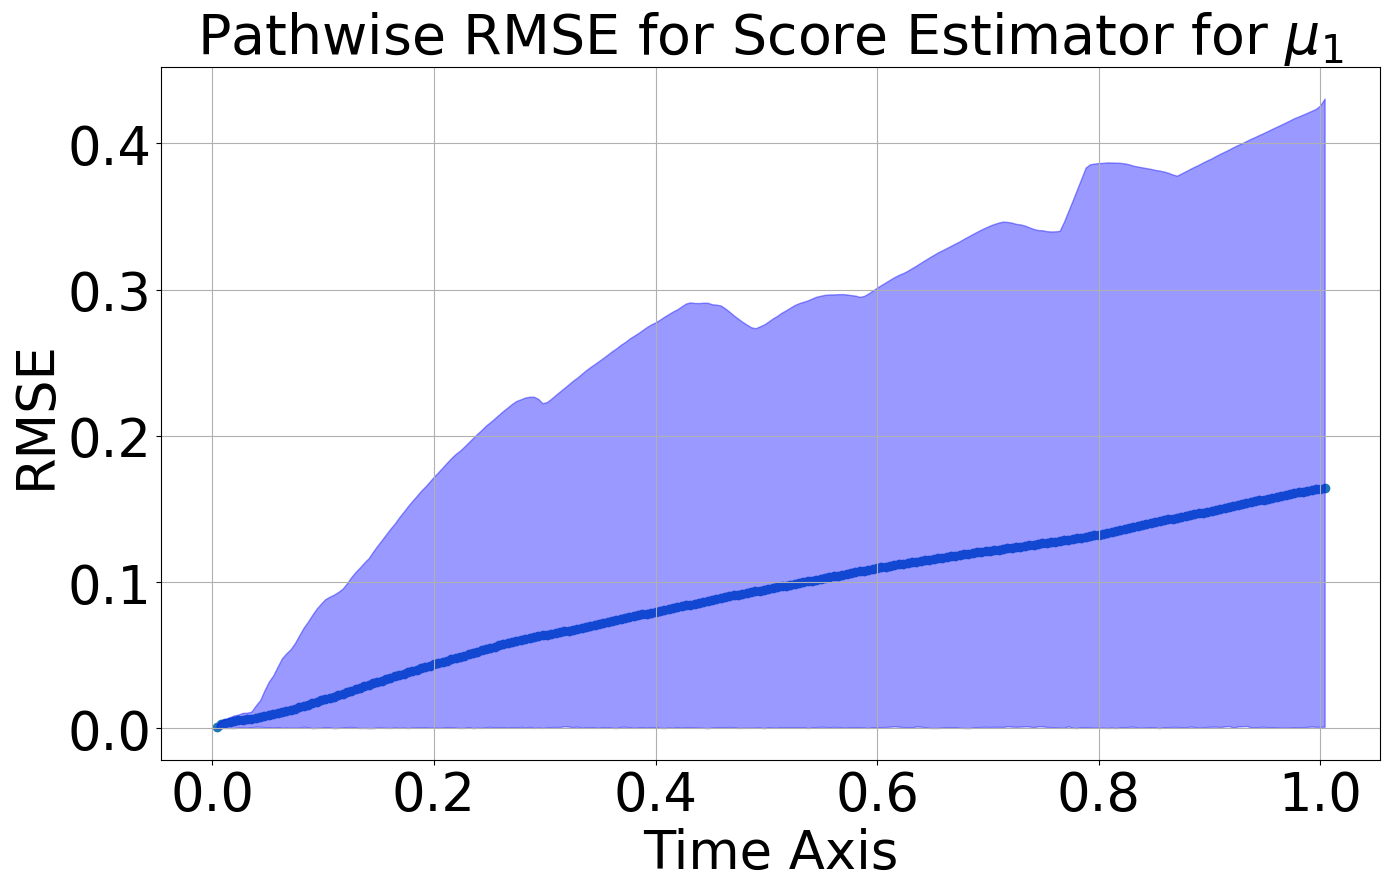

Final time cumulative MSE local-time error 0.16428703434120742 with IQR ((0.0010023971218984665, 0.4306821171260966))at Nepoch 78



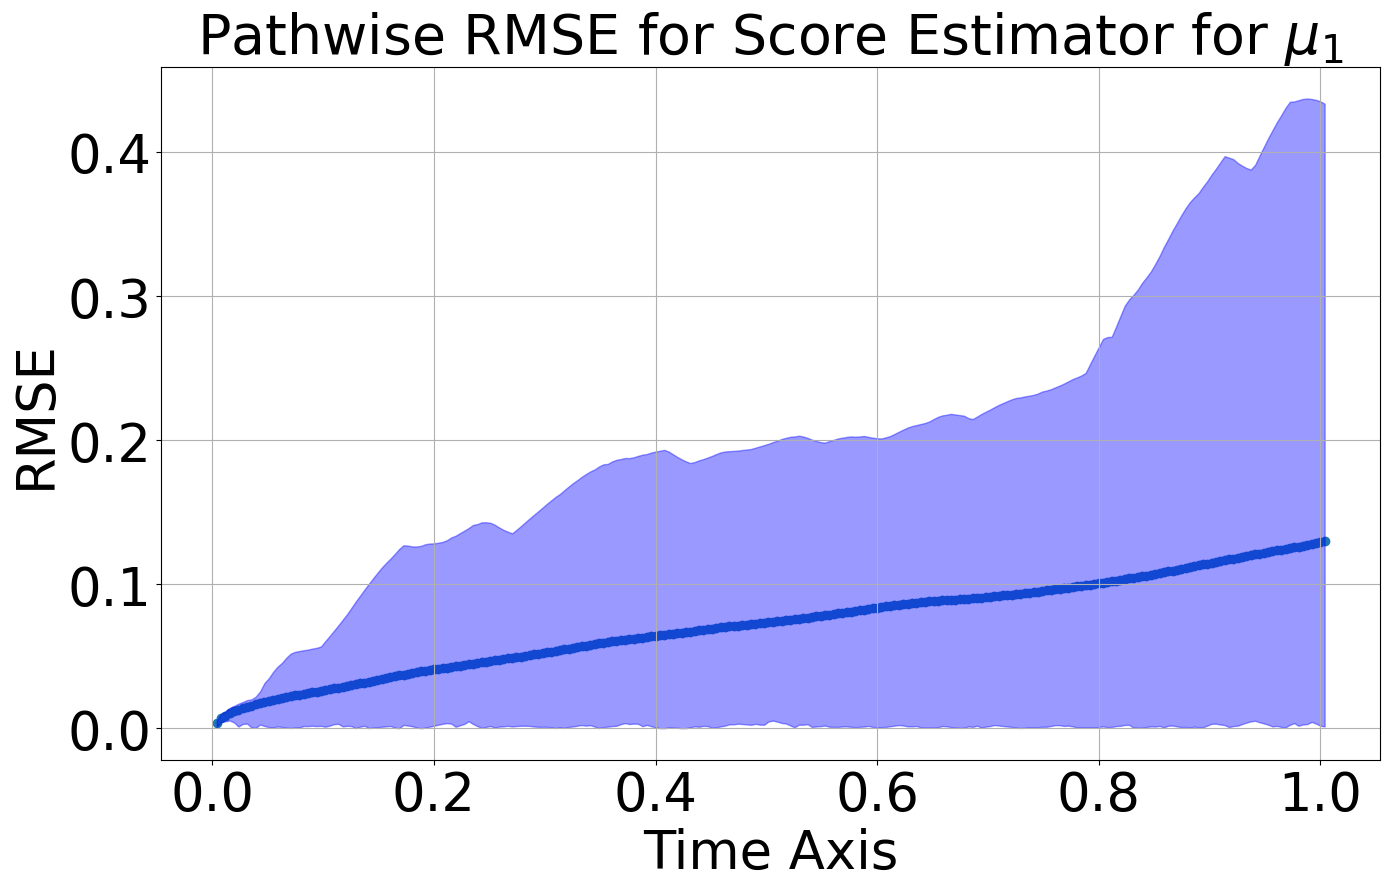

Final time cumulative MSE local-time error 0.12984192619613882 with IQR ((0.00136205801190551, 0.4334576443752021))at Nepoch 80



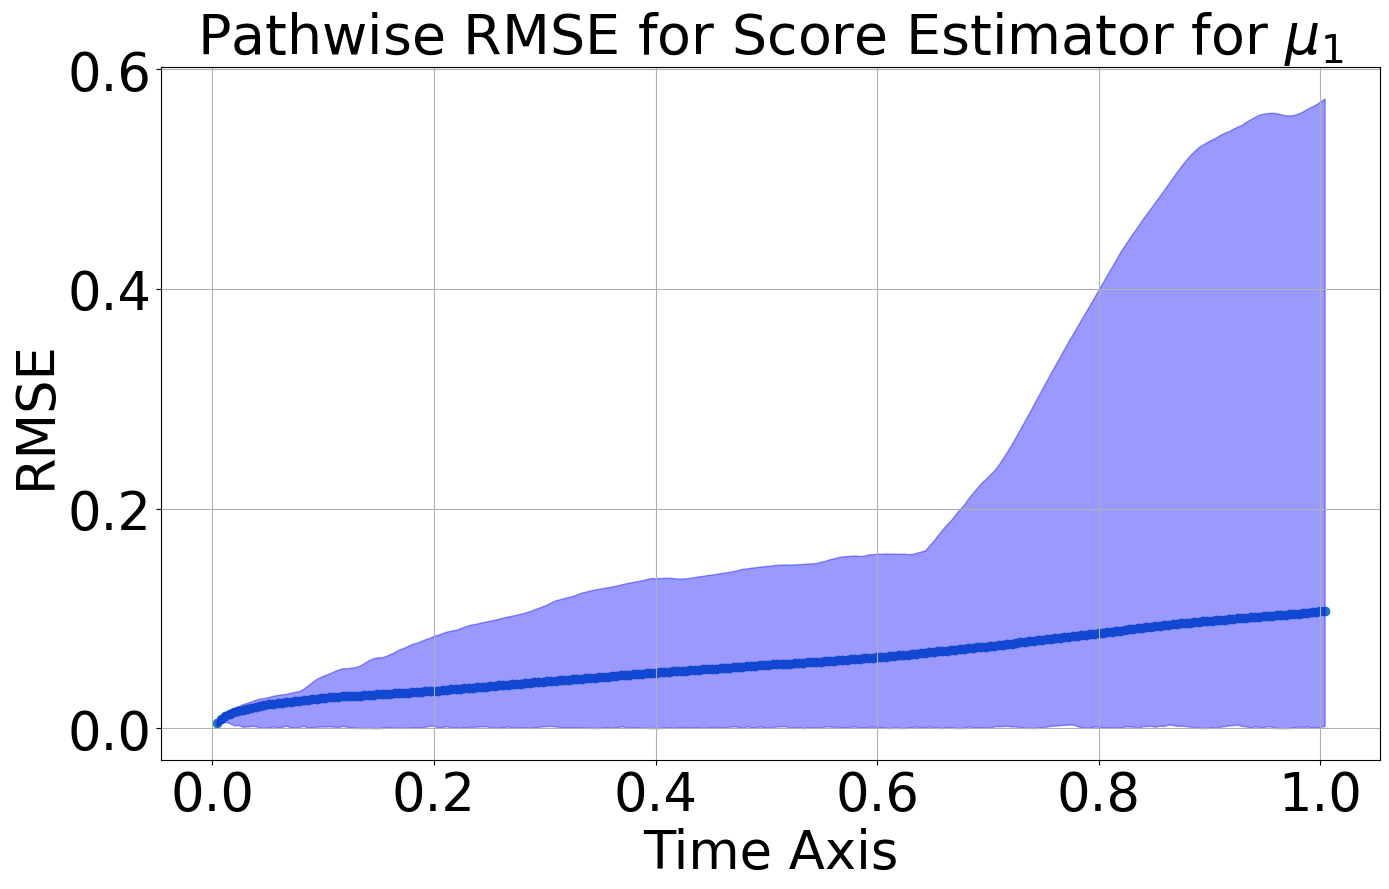

Final time cumulative MSE local-time error 0.10696668115875449 with IQR ((0.00227772236745956, 0.5734477256777191))at Nepoch 84



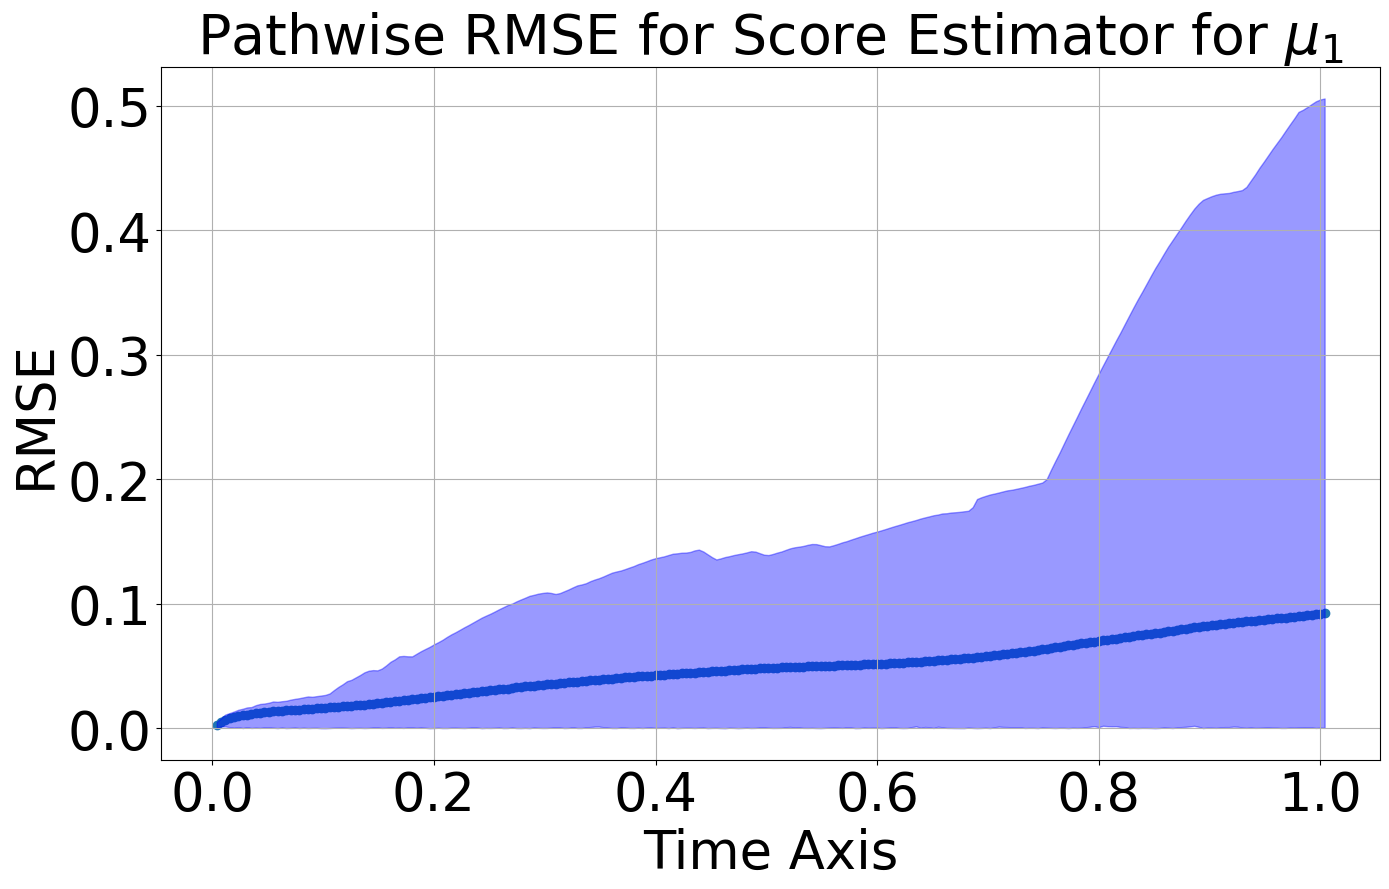

Final time cumulative MSE local-time error 0.09245107222766301 with IQR ((0.00031190433622031635, 0.5059849788187821))at Nepoch 86



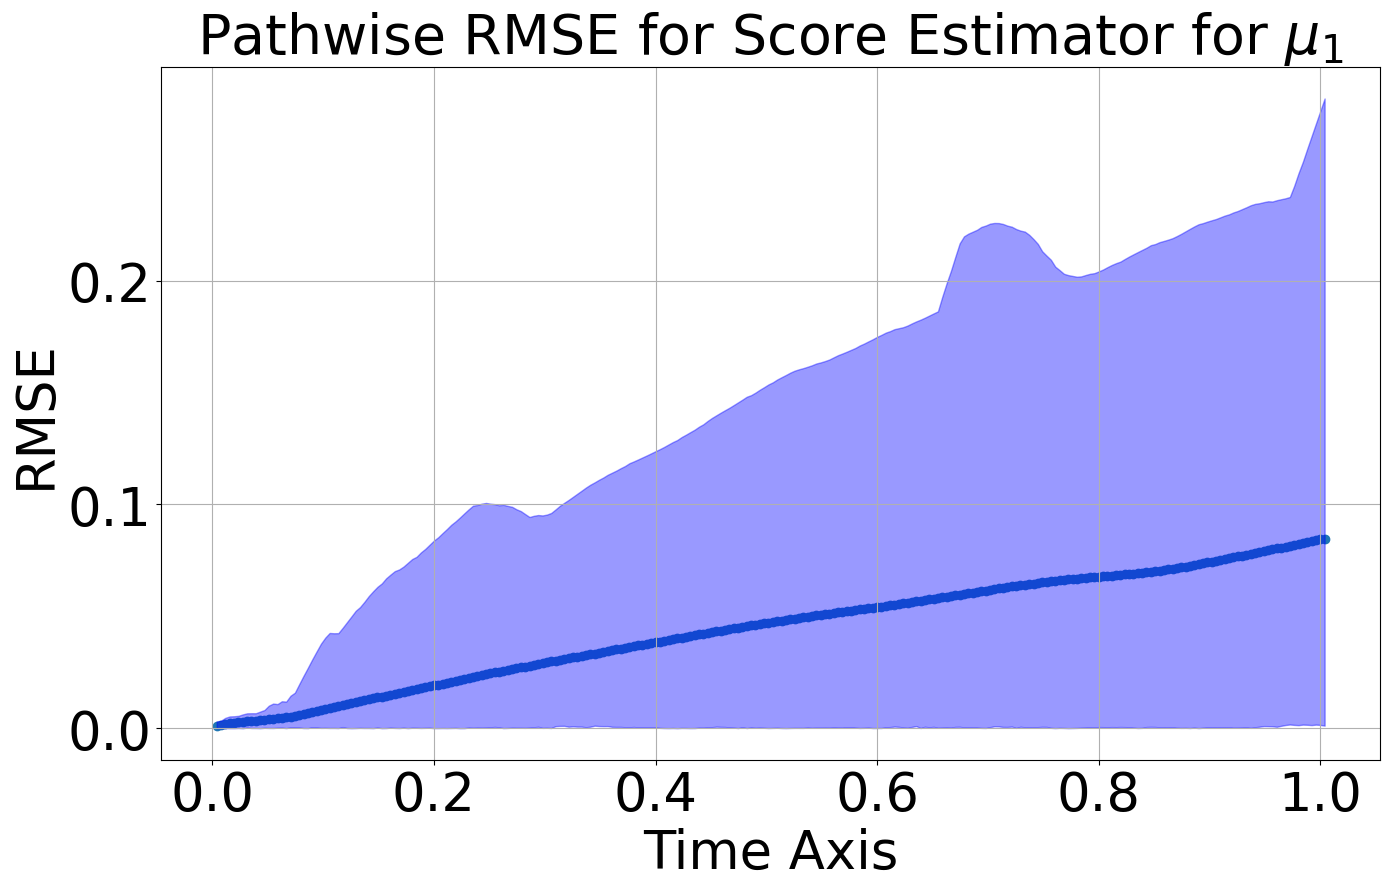

Final time cumulative MSE local-time error 0.08471525287499053 with IQR ((0.0011666242285740577, 0.2813232765771403))at Nepoch 94



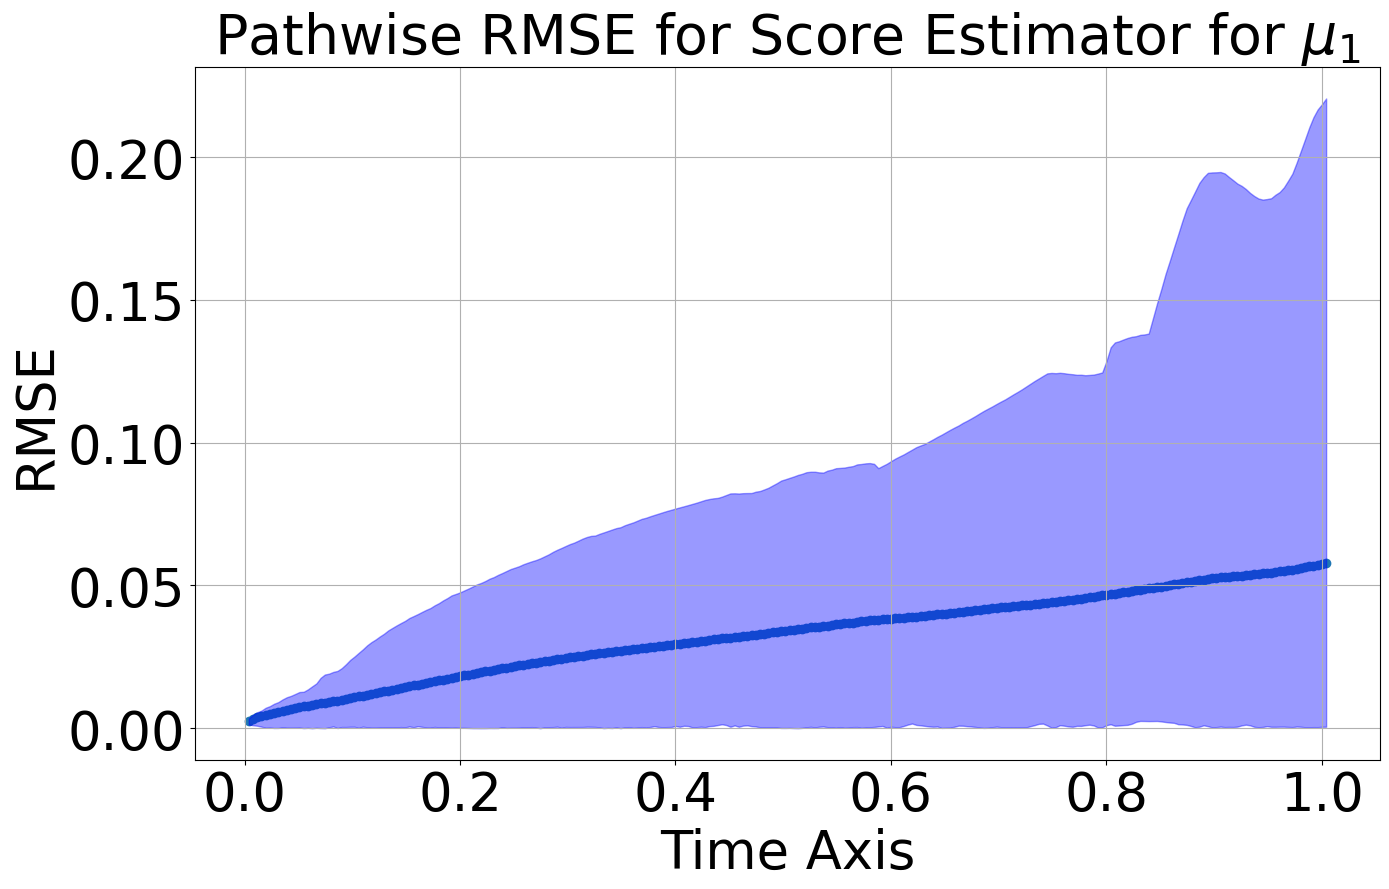

Final time cumulative MSE local-time error 0.05783265229837287 with IQR ((0.0005309786964551283, 0.22052492488739908))at Nepoch 110



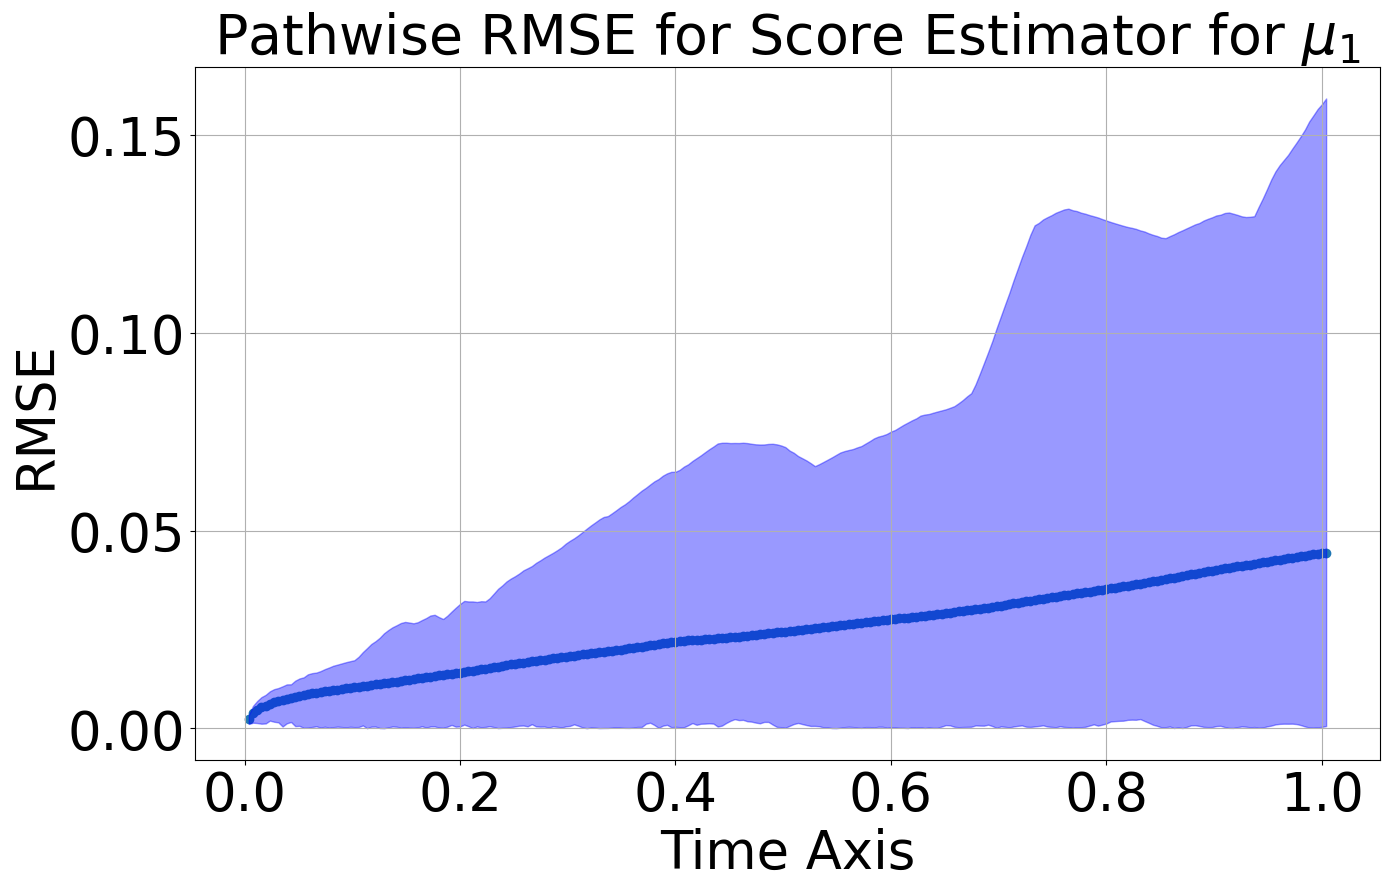

Final time cumulative MSE local-time error 0.04443421202364607 with IQR ((0.0005966618577753628, 0.15922125912502355))at Nepoch 142



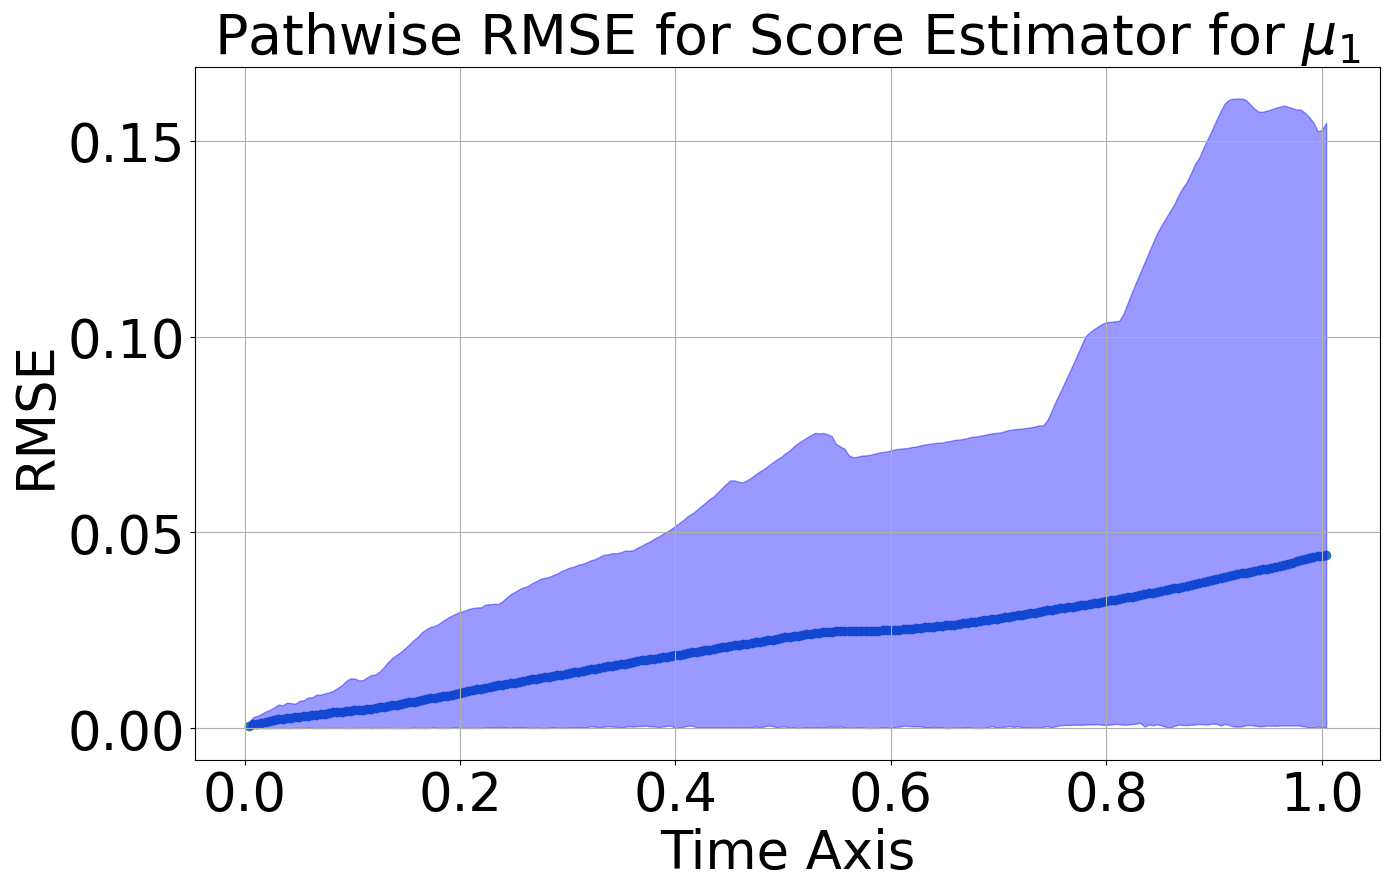

Final time cumulative MSE local-time error 0.04431944633225475 with IQR ((0.00027347276475419945, 0.1545847730843785))at Nepoch 164



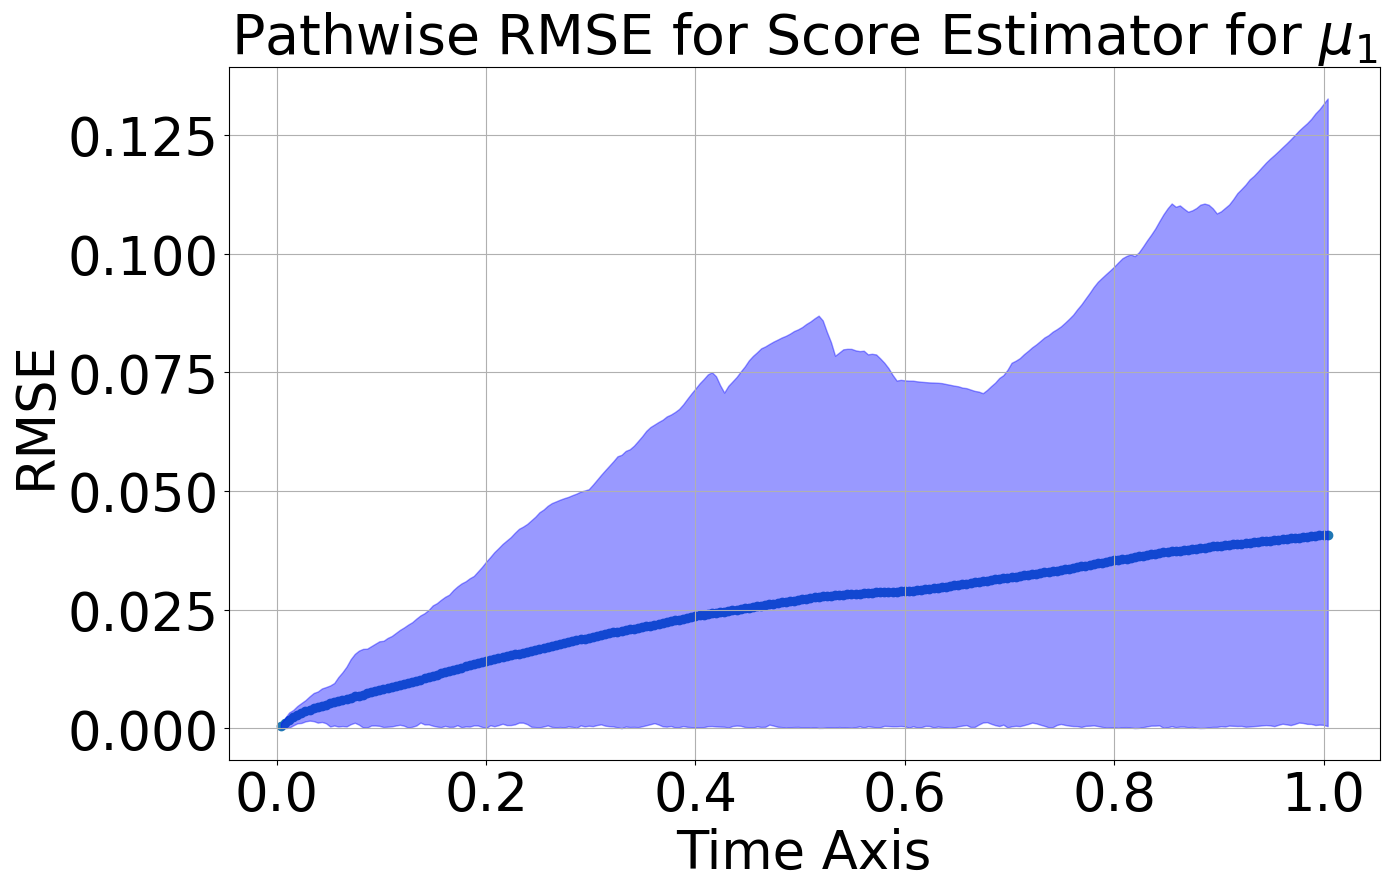

Final time cumulative MSE local-time error 0.04077465796822844 with IQR ((0.0004332482394749233, 0.1326860044016368))at Nepoch 214



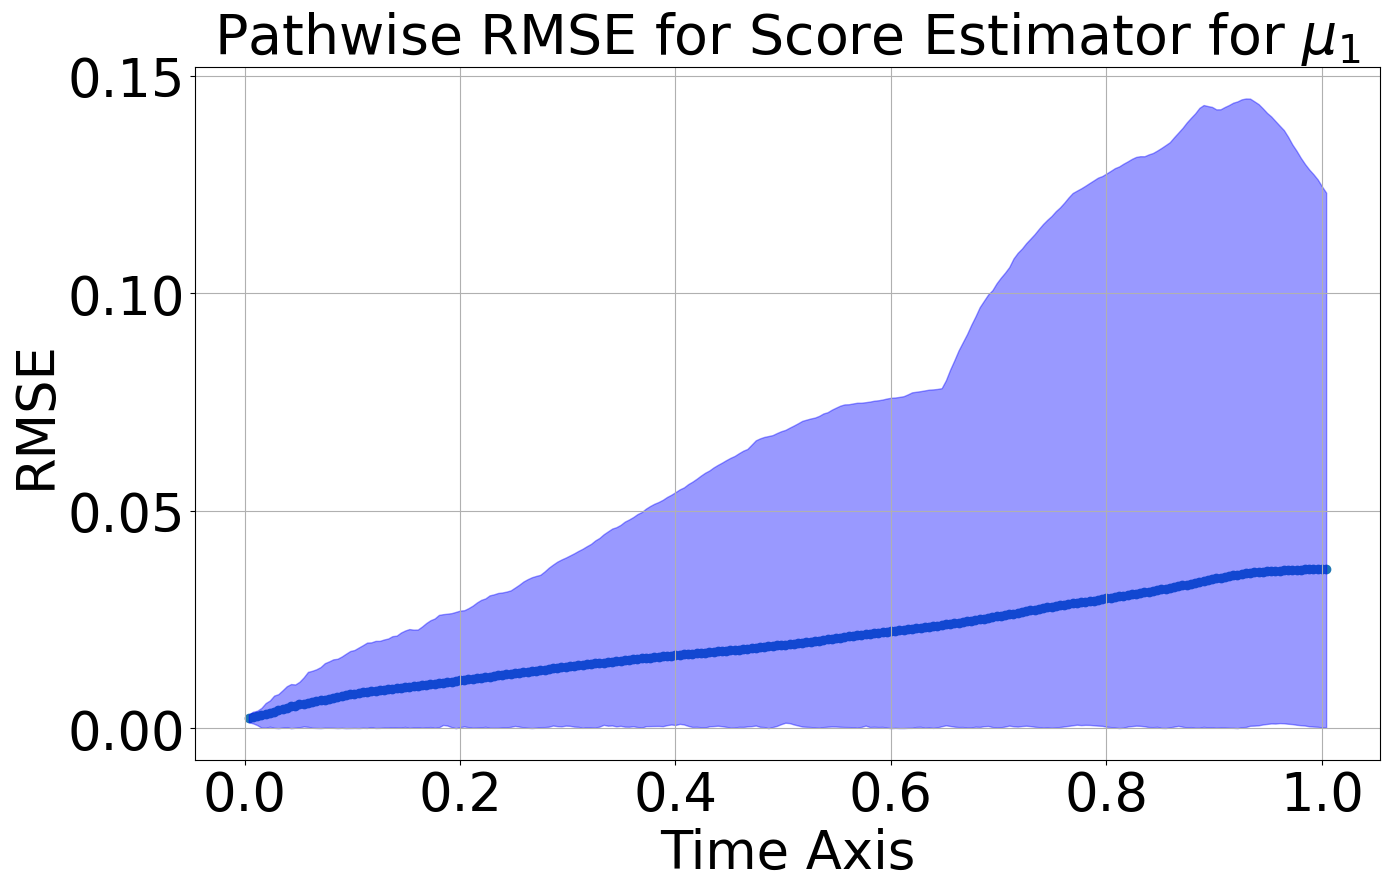

Final time cumulative MSE local-time error 0.03671038354143419 with IQR ((0.00014025945204308339, 0.12309286857008186))at Nepoch 238



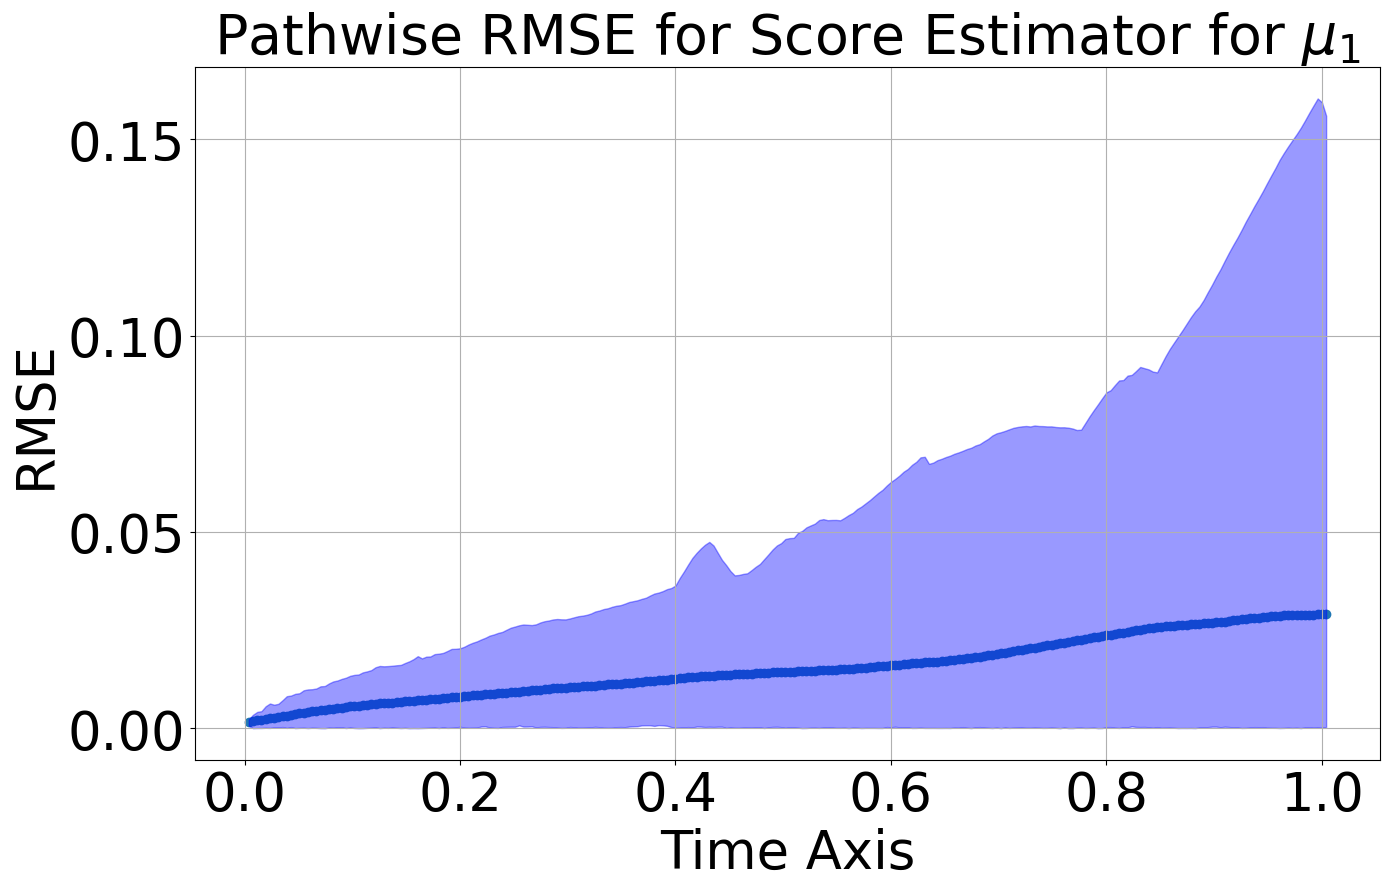

Final time cumulative MSE local-time error 0.029100337470255252 with IQR ((0.00029751244170688656, 0.15605481183014933))at Nepoch 268



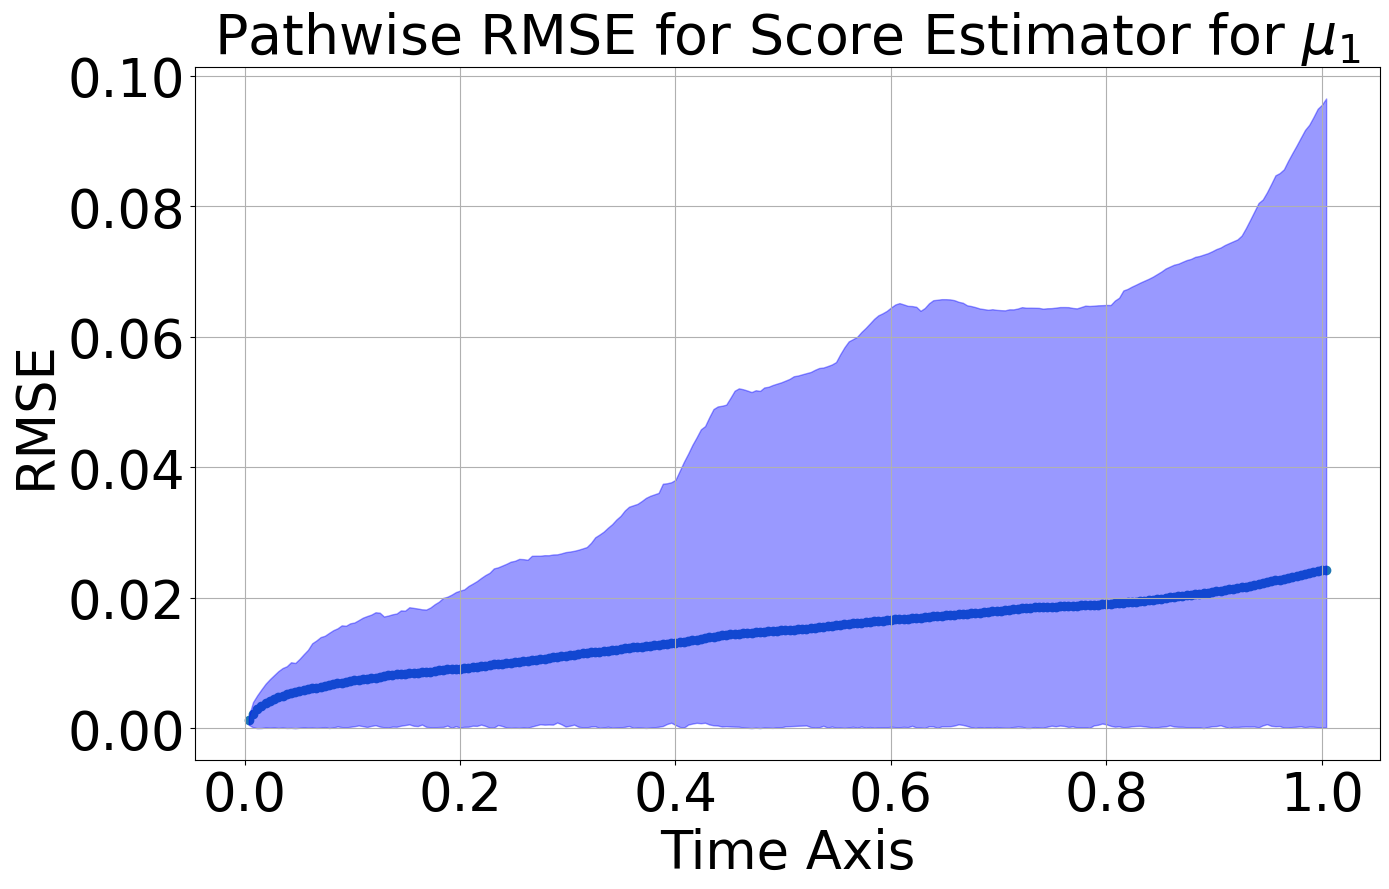

Final time cumulative MSE local-time error 0.024311810550612833 with IQR ((0.0001005037671986288, 0.09653342696179606))at Nepoch 438



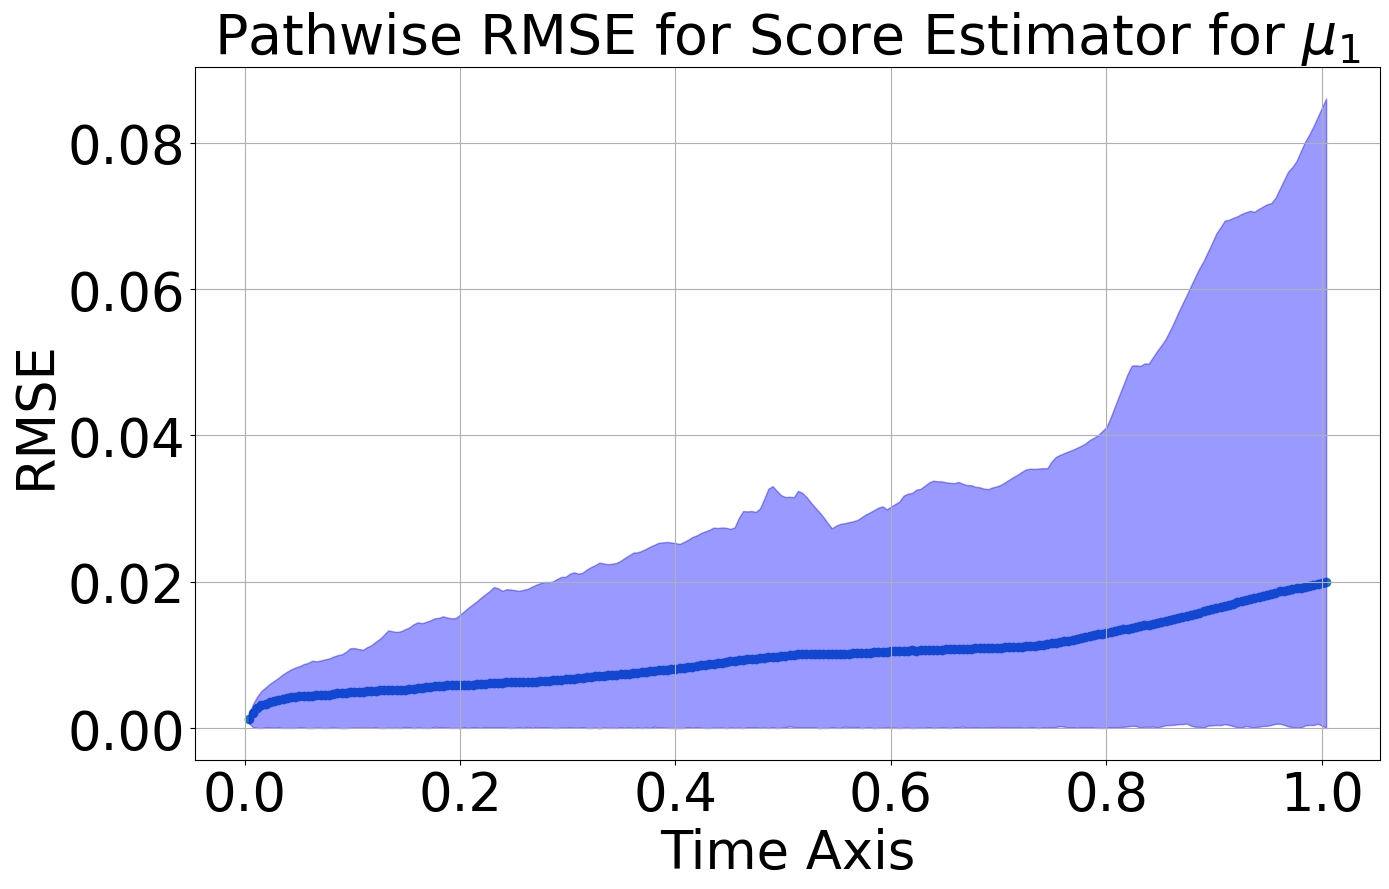

Final time cumulative MSE local-time error 0.019919004239748198 with IQR ((4.910519912422671e-05, 0.08602346589051182))at Nepoch 538



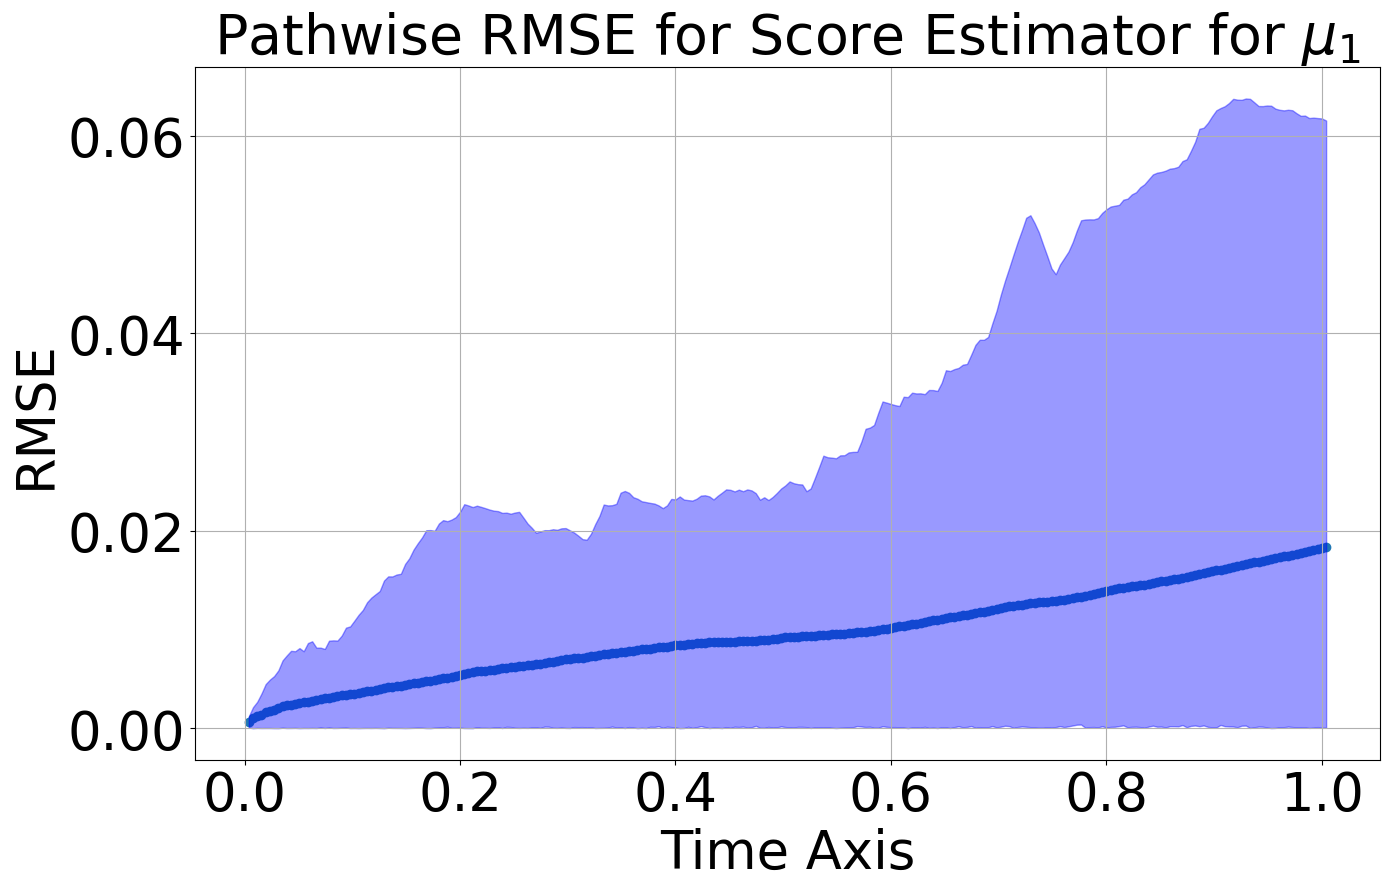

Final time cumulative MSE local-time error 0.018332884446575614 with IQR ((6.035149493501251e-05, 0.061538659222771484))at Nepoch 906



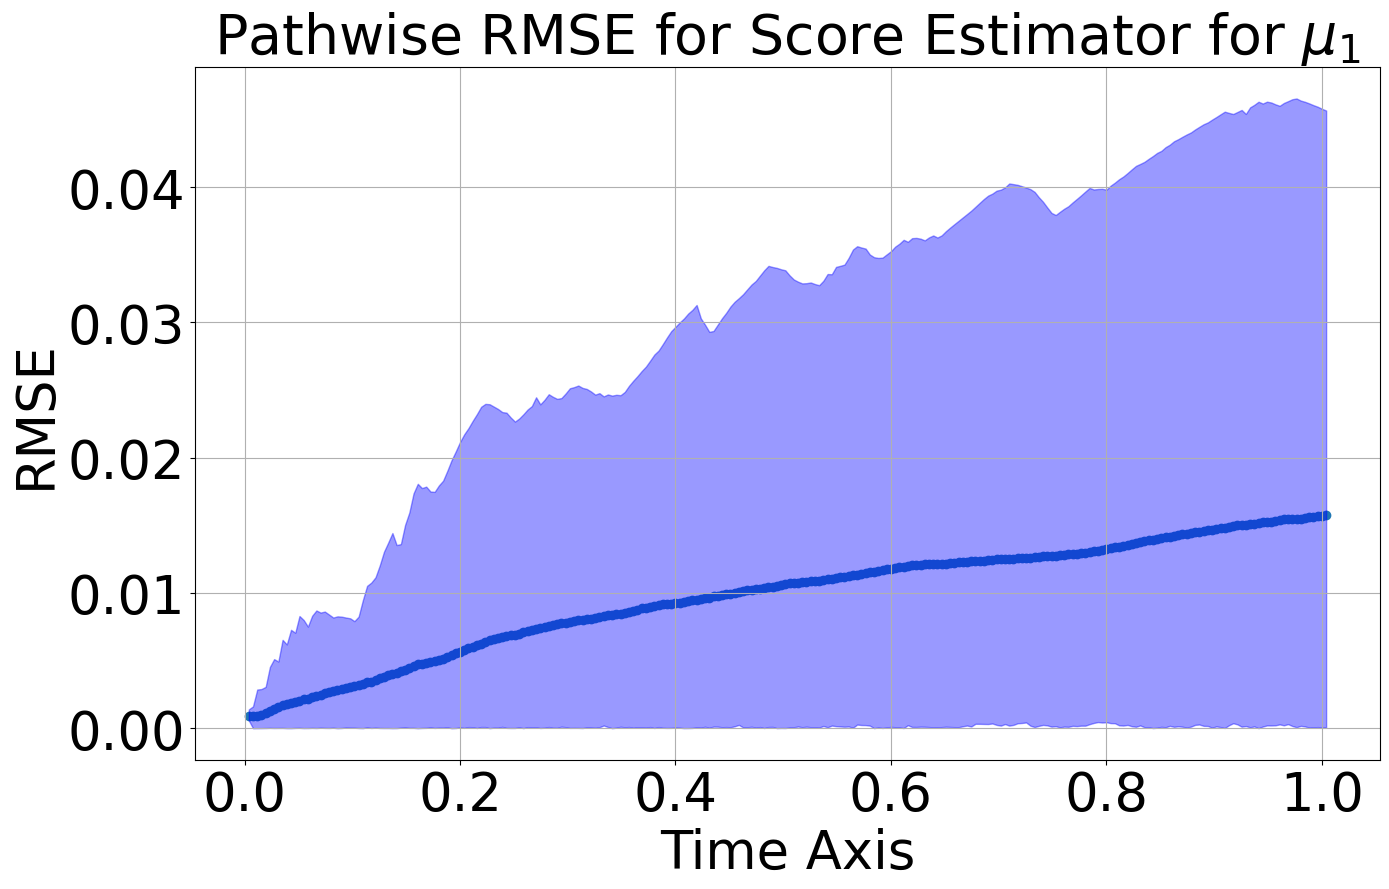

Final time cumulative MSE local-time error 0.0157554424055995 with IQR ((6.396039741426026e-05, 0.04566177436454493))at Nepoch 1550



In [103]:
curr_rmse = np.inf
toSave = True
i = 0
for file in zip(*[driftoostrack_true_files, driftoostrack_local_files, common_epochs]):
    Nepoch = file[-1]
    all_true_states = np.load(file[0])
    all_local_states = np.load(file[1])
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_local_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_local_errors = all_local_errors.reshape(-1, all_local_errors.shape[-1])
        total_local_errors = np.sqrt(np.mean((all_local_errors), axis=0))/np.sqrt(time_steps)
        all_errs = np.sqrt(all_local_errors)/np.sqrt(time_steps)
        total_local_errors[np.isinf(total_local_errors)] = 0.
        all_errs[np.isinf(all_errs)] = 0.
        total_local_errors_minq, total_local_errors_maxq = np.quantile(all_errs, axis=0,q=[0.005,0.995])
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(f"Pathwise RMSE for Score Estimator for {label}",fontsize=40)

            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)

            fig.canvas.draw()
            # Get the offset text (e.g., '1e-5')
            offset_text = ax.yaxis.get_offset_text().get_text()

            # Remove the offset text from the axis
            ax.yaxis.get_offset_text().set_visible(False)

            # Inject the scale into the y-axis label
            if offset_text:
                ax.set_ylabel(f'RMSE ({offset_text})', fontsize=38)
            else:
                ax.set_ylabel('RMSE', fontsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir +f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{ts_type}_DriftTrack_{Nepoch}Nep_{round(total_local_errors_minq[-1], 7)}_MinIQR_{round(total_local_errors_maxq[-1], 7)}_MaxIQR").replace(".", "")+".png")
            plt.grid(True)
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at Nepoch {Nepoch}\n")